In [1]:
#!pip install openpyxl
#!pip install imblearn
#!pip install mlxtend
#!pip install --upgrade numexpr --user

In [2]:
import pandas as pd
import openpyxl
import numpy as np
from pathlib import Path

In [3]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
import re
import copy
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
#from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from joblib import dump, load
np.random.seed(8)
pd.set_option('display.max_rows', 500)

In [4]:
#mlxtend.evaluate.confusion_matrix()

In [5]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import math


In [6]:
# Definição se disco C: (laptop) ou D: (desktop) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())

In [7]:
DATA_DIR = DIR_PREFIXO / "PED" / "dataset_PED"
EXPERIMENT_DIR = DIR_PREFIXO / "PED" / "experimento"
EXPERIMENT_DIR = str(EXPERIMENT_DIR)
DATASET_NAME = 'EII'
N_KFOLDS = 3
N_RUNS = 3
N_EXPERIMENTS = N_KFOLDS*N_RUNS
NUM_CLASSES = 2

In [8]:
# cols = ['ID', 'Candidato', 'Sexo', 'Data de nascimento', 'Encaminhamento',
#        'Unnamed: 5', 'Unnamed: 6', 'Primeiro atendimento', 'Unnamed: 8',
#        'Nutrição', 'Nutrição.1', 'Nutrição.2', 'Nutrição.3',
#        'HD na primeira consulta', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
#        'Unnamed: 17', 'Hemograma', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
#        'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'IgA', 'IgG', 'IgM', 'IgE',
#        'C3', 'C4', 'Anti HBS', 'Rub IgG', 'Sorologia HIV', 'Carga Viral HIV',
#        'HMG seriados', 'Sinais de Alarme', 'Unnamed: 37', 'Unnamed: 38',
#        'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42',
#        'Unnamed: 43', 'infecções profundas/sepse', 'HF de IP']

In [9]:
df = pd.read_csv(DATA_DIR / '20210702_TabelaIDP_16052021_com_label.csv')
#df.info()

# cols2 = list(df.iloc[0,:46])
# cols= list(df.iloc[:,:46].columns)
# for i in range(len(cols)):
#     if "unnamed" in cols[i].lower():
#         cols[i] = cols2[i]
#     elif "Nutrição." in cols[i]:
#         cols[i] = cols[i][:-2] + " " + cols2[i]

# df = df.iloc[10:,:46]
# df.columns = cols
df.head()

Candidato      Sexo Data de nascimento         Estado    Cidade  \
0      Sim    1 - FEM           2/7/2013  1 - SÃO PAULO  CAMPINAS   
1       Não   1 - FEM           4/1/2014  1 - SÃO PAULO  CAMPINAS   
2       Não  2 - MASC           2/6/2017  1 - SÃO PAULO  SOROCABA   
3       Não   1 - FEM          5/25/2013  1 - SÃO PAULO    SUMARÉ   
4       Não   1 - FEM          5/29/2015  1 - SÃO PAULO  CAMPINAS   

         Local Primeiro atendimento        Faixa_idade        Nutrição  \
0  4 - UNICAMP            1/12/2018  5 - 24 A 59 MESES   2 - Eutrófico   
1  4 - UNICAMP            6/12/2015  4 - 12 A 23 MESES  1 - Desnutrido   
2  4 - UNICAMP            1/12/2018   3 - 6 A 11 MESES   2 - Eutrófico   
3  4 - UNICAMP             1/5/2018  5 - 24 A 59 MESES   2 - Eutrófico   
4      1 - UBS             20/10/17  5 - 24 A 59 MESES  1 - Desnutrido   

        DNPM  ... GT 4 otites/ano GT 2 sinusites/ano  \
0  3 - BDNPM  ...          3 – NA             3 – NA   
1  3 - BDNPM  ...     1 – Ausente        1 – Ausente   
2  3 - BDNPM  ...     1 – Ausente        1 – Ausente   
3  3 - BDNPM  ...     1 – Ausente        1 – Ausente   
4  3 - BDNPM  ...     1 – Ausente        1 – Ausente   

  Uso de atb > 2 meses com pouco efeito GT 2 pneumonias/ ano  \
0                           1 – Ausente         2 – Presente   
1                           1 – Ausente          1 – Ausente   
2                           1 – Ausente          1 – Ausente   
3                           1 – Ausente         2 – Presente   
4                           1 – Ausente          1 – Ausente   

  Baixo ganho ponderal ou estatural Abscessos recorrentes  \
0                       1 – Ausente           1 – Ausente   
1                      2 – Presente           1 – Ausente   
2                       1 – Ausente           1 – Ausente   
3                       1 – Ausente           1 – Ausente   
4                      2 – Presente           1 – Ausente   

  Candidíase oral/fungo em pele persistente Necessidade de Atb EV  \
0                               1 – Ausente          2 – Presente   
1                               1 – Ausente          2 – Presente   
2                               1 – Ausente           1 – Ausente   
3                               1 – Ausente          2 – Presente   
4                               1 – Ausente           1 – Ausente   

  GT 2 infecções profundas/sepse     HF de IP  
0                    1 – Ausente  1 – Ausente  
1                   2 – Presente  1 – Ausente  
2                    1 – Ausente  1 – Ausente  
3                    1 – Ausente  1 – Ausente  
4                    1 – Ausente  1 – Ausente  

[5 rows x 45 columns]

In [10]:
df.columns

Index(['Candidato', 'Sexo', 'Data de nascimento', 'Estado', 'Cidade', 'Local',
       'Primeiro atendimento', 'Faixa_idade', 'Nutrição', 'DNPM', 'Vacinação',
       'Erro alimentar', 'Atopia', 'Imunodeficiência', 'Autoimunidade',
       'Reação vacinal', 'hd_primeira_consulta__outra', 'Anemia', 'Leucopenia',
       'Neutropenia', 'Linfopenia', 'Plaquetopenia', 'Eosenofilia',
       'hemograma__outro', 'IgA', 'IgG', 'IgM', 'IgE', 'C3', 'C4', 'Anti HBS',
       'Rub IgG', 'Sorologia HIV', 'Carga Viral HIV', 'HMG seriados',
       'GT 4 otites/ano', 'GT 2 sinusites/ano',
       'Uso de atb > 2 meses com pouco efeito', 'GT 2 pneumonias/ ano',
       'Baixo ganho ponderal ou estatural', 'Abscessos recorrentes',
       'Candidíase oral/fungo em pele persistente', 'Necessidade de Atb EV',
       'GT 2 infecções profundas/sepse', 'HF de IP'],
      dtype='object')

In [11]:
# remove os espaços em branco e coloca em minúsculo os campos tipo string de todas as linhas
for col in df.columns:
    df[col] = df[col].map(lambda x: x.lower().replace(' ','') if type(x)==str else x)



In [12]:
def remove_branco(campo):
    if type(campo) == str:
        return campo.lower().replace(' ','')
    else:
        return campo

In [13]:
#for col in df.columns:
#    df[col] = df[col].map(lambda x: x.lower().replace(' ','') if type(x)==str else x)

In [14]:
df

Candidato    Sexo Data de nascimento         Estado  \
0            sim   1-fem           2/7/2013     1-sãopaulo   
1            não   1-fem           4/1/2014     1-sãopaulo   
2            não  2-masc           2/6/2017     1-sãopaulo   
3            não   1-fem          5/25/2013     1-sãopaulo   
4            não   1-fem          5/29/2015     1-sãopaulo   
5    nãoseaplica  2-masc           6/9/2001     1-sãopaulo   
6            não  2-masc          5/28/2017     1-sãopaulo   
7            não  2-masc          3/25/2015     1-sãopaulo   
8            sim  2-masc          3/11/2008     1-sãopaulo   
9            não   1-fem          8/13/2014  2-outroestado   
10           não   1-fem           1/4/2015     1-sãopaulo   
11           sim   1-fem          12/3/2004     1-sãopaulo   
12           não  2-masc          3/14/2016     1-sãopaulo   
13           não   1-fem          1/22/2016     1-sãopaulo   
14           sim  2-masc          2/28/2014     1-sãopaulo   
15           sim  2-masc          4/18/2010     1-sãopaulo   
16           não   1-fem          9/10/2005     1-sãopaulo   
17           não   1-fem          5/30/2012     1-sãopaulo   
18           não  2-masc          5/20/2007     1-sãopaulo   
19           não   1-fem           9/4/2012     1-sãopaulo   
20           não  2-masc           7/1/2000            NaN   
21           sim   1-fem          12/3/2012     1-sãopaulo   
22           não   1-fem          1/15/2010     1-sãopaulo   
23           não  2-masc           6/4/2010     1-sãopaulo   
24           não   1-fem          7/28/2007     1-sãopaulo   
25           não   1-fem           15/10/09     1-sãopaulo   
26           sim   1-fem           2/8/2017     1-sãopaulo   
27           não   1-fem          9/23/2013     1-sãopaulo   
28           não   1-fem          5/28/2004     1-sãopaulo   
29           não  2-masc         21/11/2011     1-sãopaulo   
30           sim   1-fem          6/10/2012     1-sãopaulo   
31           sim  2-masc         11/11/2013     1-sãopaulo   
32           sim   1-fem          29/5/2015     1-sãopaulo   
33           não  2-masc         26/12/2007     1-sãopaulo   
34           sim   1-fem          17/6/2017     1-sãopaulo   
35           não   1-fem           7/2/2013     1-sãopaulo   
36           não   1-fem          15/6/2007     1-sãopaulo   
37           não  2-masc         30/10/2016     1-sãopaulo   
38           não   1-fem           3/5/2015     1-sãopaulo   
39           não   1-fem          18/9/2015     1-sãopaulo   
40           sim   1-fem          13/5/2007     1-sãopaulo   
41           sim   1-fem          16/2/2013     1-sãopaulo   
42           sim  2-masc          14/3/2016     1-sãopaulo   
43           não  2-masc           6/5/2010     1-sãopaulo   
44           não   1-fem          11/9/2013     1-sãopaulo   
45           não  2-masc          10/4/2006     1-sãopaulo   
46           sim   1-fem          24/6/2004     1-sãopaulo   
47           não   1-fem          26/8/2016     1-sãopaulo   
48           sim   1-fem          23/4/2010     1-sãopaulo   
49           sim   1-fem         30/10/2016     1-sãopaulo   
50           sim  2-masc           2/2/2006     1-sãopaulo   
51           não  2-masc           9/6/2001     1-sãopaulo   
52           sim   1-fem         27/10/2009     1-sãopaulo   
53           sim   1-fem          29/3/2007     1-sãopaulo   
54           sim  2-masc          20/7/2012     1-sãopaulo   
55           sim  2-masc          12/1/2011     1-sãopaulo   
56           sim  2-masc          4/12/2013     1-sãopaulo   
57           sim  2-masc         11/14/2014     1-sãopaulo   
58           não  2-masc          6/24/2007     1-sãopaulo   
59   nãoseaplica  2-masc          7/20/2013     1-sãopaulo   
60           não  2-masc          4/15/2013     1-sãopaulo   
61           não  2-masc          3/22/2010     1-sãopaulo   
62           não  2-masc          2/13/2002     1-sãopaulo   
63   nãoseaplica  2-masc         11/28/

Sexo:
1 - FEM
2 - MASC


Estado:
1 - SÃO PAULO
2 - OUTRO ESTADO


Local:
1 - UBS
2- CONVENIO
3 - PRIVADO
4 - UNICAMP
5 - Hospitais
6 - NA


Faixa Idade:
1 - < 1 MÊS
2 - 1 a 5 MESES
3 - 6 A 11 MESES
4 - 12 A 23 MESES
5 - 24 A 59 MESES
6 - 60 A 119 MESES
7 - 120 A 215 MESES
8 - > 216 Meses


Nutrição:
1 - Desnutrido
2 - Eutrófico
3 - Sobrepeso
4 - Obeso


DNPM:
1 - RDNPM
2 - ADNPM
3 - BDNPM
4- NA


Vacinação:
1 - Em dia
2 - Atrasada
3 - Não iniciada
4 - NA


Erro alimentar:
1 - Ausente/NA
2 - Presente


Atopia: Asma/ RA/ DA/ Urticaria/ Angioedema/ Alergia alimentar/ Medicamentosa/ Outras alergias
1- Ausente
2- Presente


Imunodeficiência:
1 - Ausente
2 - Presente


Autoimunidade:
1 - Ausente
2 - Presente


Reação vacinal:
1 - Ausente
2 - Presente


Outra:
1 - Ausente
2 - Presente


Anemia:
1 - Ausente
2 - Presente


Leucopenia:
1 - Ausente
2 - Presente


Neutropenia:
1 - Ausente
2 - Presente


Linfopenia:
1 - Ausente
2 - Presente


Plaquetopenia:
1 - Ausente
2 - Presente


Eosenofilia:
1 - Ausente
2 - Presente


Outro:
1 - Ausente
2 - Presente
4 – NA


IgA:
1 - Normal
2 - Diminuída
3 - Aumentada
4 - N/A


IgG:
1 - Normal
2 - Diminuída
3 - Aumentada
4 - N/A


IgM:
1 - Normal
2 - Diminuída
3 - Aumentada
4 - N/A


IgE:
1 - Normal
2 - Diminuída
3 - Aumentada
4 - N/A


C3:
1 - Normal
2 - Diminuída
3 - Aumentada
4 - N/A


C4:
1 - Normal
2 - Diminuída
3 - Aumentada
4 - N/A


Anti HBS:
1 - Reagente
2 - Não reagente
4 - N/A


Rub IgG:
1 - Reagente
2 - Não reagente
3 - Duvidosa
4 - N/A


Sorologia HIV:
1 - NA
2 - Nao reagente
3 - Reagente


Carga Viral HIV:
1 - NA
2 - Nao reagente
3 - Reagente


HMG seriados:
1 - NA
2 - Normal
3 - Alterado


GT 4 otites/ano:
1 - Ausente
2 - Presente
3 - NA


GT 2 sinusites/ano:
1 - Ausente
2 - Presente
3 - NA


Uso de atb > 2 meses com pouco efeito:
1 - Ausente
2 - Presente
3 - NA


GT 2 pneumonias/ ano:
1 - Ausente
2 - Presente
3 - NA


Baixo ganho ponderal ou estatural:
1 - Ausente
2 - Presente
3 - NA


Abscessos recorrentes:
1 - Ausente
2 - Presente
3 - NA


Candidíase oral/fungo em pele persistente:
1 - Ausente
2 - Presente
3 - NA


Necessidade de Atb EV:
1 - Ausente
2 - Presente
3 - NA


GT 2 infecções profundas/sepse:
1 - Ausente
2 - Presente
3 - NA


HF de IP:
1 - Ausente
2 - Presente


# Tratamento dos dados

df.drop(columns=['Cidade'], inplace=True)
df.drop(columns=['Data de nascimento'], inplace=True)
df.drop(columns=['Primeiro atendimento'], inplace=True)

df['Candidato'] = df['Candidato'].str.replace(' ', '')
df = df[df['Candidato'] != 'Nãoseaplica']
df['Candidato'] = (df['Candidato'] == 'Sim').astype('int32')
df['Sexo'] = df['Sexo'].str.replace(' ', '')
df['Sexo'] = (df['Sexo'] == '2-MASC').astype('int32')
df['Estado'] = df['Estado'].str.replace(' ', '')
df['Estado'] = (df['Estado'] == '2-OUTROESTADO').astype('int32')
df['Local'] = df['Local'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Local'],drop_first=True)
df['Faixa_idade'] = df['Faixa_idade'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Faixa_idade'],drop_first=True)
df['Nutrição'] = df['Nutrição'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Nutrição'],drop_first=True)
df['DNPM'] = df['DNPM'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['DNPM'],drop_first=True)
df['Vacinação'] = df['Vacinação'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Vacinação'],drop_first=True)
df['Erro alimentar'] = df['Erro alimentar'].str.replace(' ', '')
df['Erro alimentar'] = (df['Erro alimentar'] == '2-Presente').astype('int32')
df['Atopia'] = df['Atopia'].str.replace(' ', '')
df['Atopia'] = (df['Atopia'] == '2-Presente').astype('int32')
df['Imunodeficiência'] = df['Imunodeficiência'].str.replace(' ', '')
df['Imunodeficiência'] = (df['Imunodeficiência'] == '2-Presente').astype('int32')
df['Autoimunidade'] = df['Autoimunidade'].str.replace(' ', '')
df['Autoimunidade'] = (df['Autoimunidade'] == '2-Presente').astype('int32')
df['Reação vacinal'] = df['Reação vacinal'].str.replace(' ', '')
df['Reação vacinal'] = (df['Reação vacinal'] == '2-Presente').astype('int32')
df['Outra'] = df['Outra'].str.replace(' ', '')
df['Outra'] = (df['Outra'] == '2-Presente').astype('int32')
df['Anemia'] = df['Anemia'].str.replace(' ', '')
df['Anemia'] = (df['Anemia'] == '2-Presente').astype('int32')
df['Leucopenia'] = df['Leucopenia'].str.replace(' ', '')
df['Leucopenia'] = (df['Leucopenia'] == '2-Presente').astype('int32')
df['Neutropenia'] = df['Neutropenia'].str.replace(' ', '')
df['Neutropenia'] = (df['Neutropenia'] == '2-Presente').astype('int32')
df['Linfopenia'] = df['Linfopenia'].str.replace(' ', '')
df['Linfopenia'] = (df['Linfopenia'] == '2-Presente').astype('int32')
df['Plaquetopenia'] = df['Plaquetopenia'].str.replace(' ', '')
df['Plaquetopenia'] = (df['Plaquetopenia'] == '2-Presente').astype('int32')
df['Eosenofilia'] = df['Eosenofilia'].str.replace(' ', '')
df['Eosenofilia'] = (df['Eosenofilia'] == '2-Presente').astype('int32')
df['Outro'] = df['Outro'].str.replace(' ', '')
df['Outro'] = (df['Outro'] == '2-Presente').astype('int32')
df['IgA'] = df['IgA'].str.replace(' ', '')
df['IgA'] = (df['IgA'] == '2-Presente').astype('int32')
df['IgG'] = df['IgG'].str.replace(' ', '')
df['IgG'] = (df['IgG'] == '2-Presente').astype('int32')
df['IgM'] = df['IgM'].str.replace(' ', '')
df['IgM'] = (df['IgM'] == '2-Presente').astype('int32')
df['IgE'] = df['IgE'].str.replace(' ', '')
df['IgE'] = (df['IgE'] == '2-Presente').astype('int32')
df['C3'] = df['C3'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['C3'],drop_first=True)
df['C4'] = df['C4'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['C4'],drop_first=True)
df['Anti HBS'] = df['Anti HBS'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Anti HBS'],drop_first=True)
df['Rub IgG'] = df['Rub IgG'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Rub IgG'],drop_first=True)
df['Sorologia HIV'] = df['Sorologia HIV'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Sorologia HIV'],drop_first=True)
df['Carga Viral HIV'] = df['Carga Viral HIV'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Carga Viral HIV'],drop_first=True)
df['HMG seriados'] = df['HMG seriados'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['HMG seriados'],drop_first=True)
df['GT 4 otites/ano'] = df['GT 4 otites/ano'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['GT 4 otites/ano'],drop_first=True)
df['GT 2 sinusites/ano'] = df['GT 2 sinusites/ano'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['GT 2 sinusites/ano'],drop_first=True)
df['Uso de atb > 2 meses com pouco efeito'] = df['Uso de atb > 2 meses com pouco efeito'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Uso de atb > 2 meses com pouco efeito'],drop_first=True)
df['GT 2 pneumonias/ ano'] = df['GT 2 pneumonias/ ano'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['GT 2 pneumonias/ ano'],drop_first=True)
df['Baixo ganho ponderal ou estatural'] = df['Baixo ganho ponderal ou estatural'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Baixo ganho ponderal ou estatural'],drop_first=True)
df['Abscessos recorrentes'] = df['Abscessos recorrentes'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Abscessos recorrentes'],drop_first=True)
df['Candidíase oral/fungo em pele persistente'] = df['Candidíase oral/fungo em pele persistente'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Candidíase oral/fungo em pele persistente'],drop_first=True)
df['Necessidade de Atb EV'] = df['Necessidade de Atb EV'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['Necessidade de Atb EV'],drop_first=True)
df['GT 2 infecções profundas/sepse'] = df['GT 2 infecções profundas/sepse'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['GT 2 infecções profundas/sepse'],drop_first=True)
df['HF de IP'] = df['HF de IP'].str.replace(' ', '')
df = pd.get_dummies(df,columns=['HF de IP'],drop_first=True)

In [15]:
df.drop(columns=['Cidade'], inplace=True)
df.drop(columns=['Data de nascimento'], inplace=True)
df.drop(columns=['Primeiro atendimento'], inplace=True)

In [16]:
df

Candidato    Sexo         Estado        Local     Faixa_idade  \
0            sim   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
1            não   1-fem     1-sãopaulo    4-unicamp    4-12a23meses   
2            não  2-masc     1-sãopaulo    4-unicamp     3-6a11meses   
3            não   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
4            não   1-fem     1-sãopaulo        1-ubs    5-24a59meses   
5    nãoseaplica  2-masc     1-sãopaulo        1-ubs     8->216meses   
6            não  2-masc     1-sãopaulo         6-na     3-6a11meses   
7            não  2-masc     1-sãopaulo    4-unicamp    5-24a59meses   
8            sim  2-masc     1-sãopaulo    4-unicamp   6-60a119meses   
9            não   1-fem  2-outroestado    4-unicamp    4-12a23meses   
10           não   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
11           sim   1-fem     1-sãopaulo    4-unicamp  7-120a215meses   
12           não  2-masc     1-sãopaulo  5-hospitais    4-12a23meses   
13           não   1-fem     1-sãopaulo  5-hospitais    5-24a59meses   
14           sim  2-masc     1-sãopaulo        1-ubs    5-24a59meses   
15           sim  2-masc     1-sãopaulo    4-unicamp   6-60a119meses   
16           não   1-fem     1-sãopaulo    4-unicamp  7-120a215meses   
17           não   1-fem     1-sãopaulo        1-ubs   6-60a119meses   
18           não  2-masc     1-sãopaulo    4-unicamp  7-120a215meses   
19           não   1-fem     1-sãopaulo    3-privado   6-60a119meses   
20           não  2-masc            NaN    4-unicamp  7-120a215meses   
21           sim   1-fem     1-sãopaulo        1-ubs    5-24a59meses   
22           não   1-fem     1-sãopaulo    4-unicamp   6-60a119meses   
23           não  2-masc     1-sãopaulo        1-ubs   6-60a119meses   
24           não   1-fem     1-sãopaulo        1-ubs  7-120a215meses   
25           não   1-fem     1-sãopaulo    4-unicamp   6-60a119meses   
26           sim   1-fem     1-sãopaulo    4-unicamp    4-12a23meses   
27           não   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
28           não   1-fem     1-sãopaulo    4-unicamp  7-120a215meses   
29           não  2-masc     1-sãopaulo    4-unicamp   6-60a119meses   
30           sim   1-fem     1-sãopaulo    4-unicamp   6-60a119meses   
31           sim  2-masc     1-sãopaulo        1-ubs    5-24a59meses   
32           sim   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
33           não  2-masc     1-sãopaulo         6-na   6-60a119meses   
34           sim   1-fem     1-sãopaulo    4-unicamp     3-6a11meses   
35           não   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
36           não   1-fem     1-sãopaulo         6-na   6-60a119meses   
37           não  2-masc     1-sãopaulo        1-ubs    4-12a23meses   
38           não   1-fem     1-sãopaulo         6-na    5-24a59meses   
39           não   1-fem     1-sãopaulo         6-na    5-24a59meses   
40           sim   1-fem     1-sãopaulo        1-ubs  7-120a215meses   
41           sim   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
42           sim  2-masc     1-sãopaulo    4-unicamp    4-12a23meses   
43           não  2-masc     1-sãopaulo    4-unicamp   6-60a119meses   
44           não   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
45           não  2-masc     1-sãopaulo    4-unicamp  7-120a215meses   
46           sim   1-fem     1-sãopaulo    4-unicamp    5-24a59meses   
47           não   1-fem     1-sãopaulo  5-hospitais    4-12a23meses   
48           sim   1-fem     1-sãopaulo    4-unicamp   6-60a119meses   
49           sim   1-fem     1-sãopaulo    4-unicamp     3-6a11meses   
50           sim  2-masc     1-sãopaulo    4-unicamp    5-24a59meses   
51           não  2-masc     1-sãopaulo  5-hospitais  7-120a215meses   
52           sim   1-fem     1-sãopaulo    4-unicamp   6-60a119meses   
53           sim   1-fem     1-sãopaulo    4-unicamp  7-120a215meses   
54           sim  2-masc     1-sãopaulo   2-con

In [17]:
df = df[df['Candidato'] != 'nãoseaplica']
df['Estado'].replace('2-outroestado','2-outro', inplace=True)
df['Vacinação'].replace('2atrasada','2-atrasada', inplace=True)
df['Nutrição'].replace('2eutrófico','2-eutrófico', inplace=True)
df['Erro alimentar'].replace('1-ausente/na','1-ausente', inplace=True)
df['Erro alimentar'].replace('1-presente','2-presente', inplace=True)
df['Reação vacinal'].replace('1–ausente','1-ausente', inplace=True)
df['hd_primeira_consulta__outra'].replace('1–ausente','1-ausente', inplace=True)
df['Anemia'].replace('1–ausente','1-ausente', inplace=True)
df['Leucopenia'].replace('1–ausente','1-ausente', inplace=True)
df['Neutropenia'].replace('1–ausente','1-ausente', inplace=True)
df['Linfopenia'].replace('1–ausente','1-ausente', inplace=True)
df['Plaquetopenia'].replace('1–ausente','1-ausente', inplace=True)
df['Eosenofilia'].replace('1–ausente','1-ausente', inplace=True)
df['hemograma__outro'].replace('1–ausente','1-ausente', inplace=True)
df['IgG'].replace('1-diminuída','2-diminuída', inplace=True)
df['IgM'].replace('1-diminuída','2-diminuída', inplace=True)
df['IgE'].replace('4-na','4-n/a', inplace=True)
df['C3'].replace('1–normal','1-normal', inplace=True)
df['C3'].replace('2-diminuído','2-diminuída', inplace=True)
df['C3'].replace('4-na','4-n/a', inplace=True)
df['C4'].replace('1–normal','1-normal', inplace=True)
df['C4'].replace('2-diminuído','2-diminuída', inplace=True)
df['C4'].replace('3-diminuído','2-diminuída', inplace=True)
df['C4'].replace('4-na','4-n/a', inplace=True)
df['Anti HBS'].replace('2-naoreagente','2-nãoreagente', inplace=True)
df['Anti HBS'].replace('4-na','4-n/a', inplace=True)
df['Anti HBS'].replace('2-reagente','1-reagente', inplace=True)
df['Anti HBS'].replace('4-reagente','1-reagente', inplace=True)
df['Anti HBS'].replace('5-reagente','1-reagente', inplace=True)
df['Anti HBS'].replace('6-reagente','1-reagente', inplace=True)
df['Rub IgG'].replace('2-naoreagente','2-nãoreagente', inplace=True)
df['Rub IgG'].replace('2-reagente','1-reagente', inplace=True)
df['Rub IgG'].replace('4-na','4-n/a', inplace=True)
df['Rub IgG'].replace('3-reagente','1-reagente', inplace=True)
df['Sorologia HIV'].replace('2-naoreagente','2-nãoreagente', inplace=True)
df['Carga Viral HIV'].replace('2-naoreagente','2-nãoreagente', inplace=True)
df['GT 4 otites/ano'].replace('1ausente','1-ausente', inplace=True)
df['GT 4 otites/ano'].replace('1–ausente','1-ausente', inplace=True)
df['GT 4 otites/ano'].replace('2–presente','2-presente', inplace=True)
df['GT 4 otites/ano'].replace('2presente','2-presente', inplace=True)
df['GT 2 sinusites/ano'].replace('1–ausente','1-ausente', inplace=True)
df['GT 2 sinusites/ano'].replace('1ausente','1-ausente', inplace=True)
df['GT 2 sinusites/ano'].replace('2–presente','2-presente', inplace=True)
df['GT 2 sinusites/ano'].replace('2presente','2-presente', inplace=True)
df['Uso de atb > 2 meses com pouco efeito'].replace('1–ausente','1-ausente', inplace=True)
df['Uso de atb > 2 meses com pouco efeito'].replace('2–presente','2-presente', inplace=True)
df['Uso de atb > 2 meses com pouco efeito'].replace('1ausente','1-ausente', inplace=True)
df['Uso de atb > 2 meses com pouco efeito'].replace('2presente','2-presente', inplace=True)
df['GT 2 pneumonias/ ano'].replace('1ausente','1-ausente', inplace=True)
df['GT 2 pneumonias/ ano'].replace('2presente','2-presente', inplace=True)
df['GT 2 pneumonias/ ano'].replace('1–ausente','1-ausente', inplace=True)
df['GT 2 pneumonias/ ano'].replace('2–presente','2-presente', inplace=True)
df['Baixo ganho ponderal ou estatural'].replace('1ausente','1–ausente', inplace=True)
df['Baixo ganho ponderal ou estatural'].replace('2presente','2–presente', inplace=True)
df['Baixo ganho ponderal ou estatural'].replace('1–ausente','1-ausente', inplace=True)
df['Baixo ganho ponderal ou estatural'].replace('2–presente','2-presente', inplace=True)
df['Abscessos recorrentes'].replace('1ausente','1–ausente', inplace=True)
df['Abscessos recorrentes'].replace('1–ausente','1-ausente', inplace=True)
df['Abscessos recorrentes'].replace('2–presente','2-presente', inplace=True)
df['Candidíase oral/fungo em pele persistente'].replace('1ausente','1-ausente', inplace=True)
df['Candidíase oral/fungo em pele persistente'].replace('2presente','2-presente', inplace=True)
df['Candidíase oral/fungo em pele persistente'].replace('1–ausente','1-ausente', inplace=True)
df['Candidíase oral/fungo em pele persistente'].replace('2–presente','2-presente', inplace=True)
df['Necessidade de Atb EV'].replace('1ausente','1-ausente', inplace=True)
df['Necessidade de Atb EV'].replace('2presente','2-presente', inplace=True)
df['Necessidade de Atb EV'].replace('1–ausente','1-ausente', inplace=True)
df['Necessidade de Atb EV'].replace('2–presente','2-presente', inplace=True)
df['GT 2 infecções profundas/sepse'].replace('1ausente','1-ausente', inplace=True)
df['GT 2 infecções profundas/sepse'].replace('1–ausente','1-ausente', inplace=True)
df['GT 2 infecções profundas/sepse'].replace('2–presente','2-presente', inplace=True)
df['HF de IP'].replace('1ausente','1-ausente', inplace=True)
df['HF de IP'].replace('2presente','2-presente', inplace=True)
df['HF de IP'].replace('1–ausente','1-ausente', inplace=True)
df['HF de IP'].replace('2–presente','2-presente', inplace=True)

<ipython-input-17-5252c7c137ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Estado'].replace('2-outroestado','2-outro', inplace=True)
<ipython-input-17-5252c7c137ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vacinação'].replace('2atrasada','2-atrasada', inplace=True)
<ipython-input-17-5252c7c137ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Nutrição'].replace('2eutrófico','2-eutrófico', inplace=True)
<ipyt

In [18]:
for col in df.columns:
    print('col', col)
    print(df[col].value_counts())
    print('')

col Candidato
sim    133
não    130
Name: Candidato, dtype: int64

col Sexo
2-masc    148
1-fem     115
Name: Sexo, dtype: int64

col Estado
1-sãopaulo    250
2-outro        12
Name: Estado, dtype: int64

col Local
4-unicamp      156
1-ubs           60
5-hospitais     20
6-na            16
3-privado       10
2-convenio       1
Name: Local, dtype: int64

col Faixa_idade
6-60a119meses     80
7-120a215meses    61
5-24a59meses      58
4-12a23meses      31
3-6a11meses       17
2-1a5meses        12
8->216meses        4
Name: Faixa_idade, dtype: int64

col Nutrição
2-eutrófico     196
1-desnutrido     39
4-obeso          21
3-sobrepeso       7
Name: Nutrição, dtype: int64

col DNPM
3-bdnpm    223
2-adnpm     23
1-rdnpm     15
4-na         2
Name: DNPM, dtype: int64

col Vacinação
1-emdia       202
2-atrasada     56
4-na            5
Name: Vacinação, dtype: int64

col Erro alimentar
1-ausente     192
2-presente     71
Name: Erro alimentar, dtype: int64

col Atopia
1-ausente     138
2-presente 

In [19]:
df['Candidato'] = (df['Candidato'] == 'sim').astype('int32')
df['Sexo'] = (df['Sexo'] == '2-masc').astype('int32')
df['Estado'] = (df['Estado'] == '1-sãopaulo').astype('int32')
df = pd.get_dummies(df,columns=['Local'])
df = pd.get_dummies(df,columns=['Faixa_idade'])
df = pd.get_dummies(df,columns=['Nutrição'])
df = pd.get_dummies(df,columns=['DNPM'])
df = pd.get_dummies(df,columns=['Vacinação'])
df['Erro alimentar'] = (df['Erro alimentar'] == '2-presente').astype('int32')
df['Atopia'] = (df['Atopia'] == '2-presente').astype('int32')
df['Imunodeficiência'] = (df['Imunodeficiência'] == '2-presente').astype('int32')
df['Autoimunidade'] = (df['Autoimunidade'] == '2-presente').astype('int32')
df['Reação vacinal'] = (df['Reação vacinal'] == '2-presente').astype('int32')
df['hd_primeira_consulta__outra'] = (df['hd_primeira_consulta__outra'] == '2-presente').astype('int32')
df['Anemia'] = (df['Anemia'] == '2-presente').astype('int32')
df['Leucopenia'] = (df['Leucopenia'] == '2-presente').astype('int32')
df['Neutropenia'] = (df['Neutropenia'] == '2-presente').astype('int32')
df['Linfopenia'] = (df['Linfopenia'] == '2-presente').astype('int32')
df['Plaquetopenia'] = (df['Plaquetopenia'] == '2-presente').astype('int32')
df['Eosenofilia'] = (df['Eosenofilia'] == '2-presente').astype('int32')
df['hemograma__outro'] = (df['hemograma__outro'] == '2-presente').astype('int32')
df['IgA'] = (df['IgA'] == '2-presente').astype('int32')
df['IgG'] = (df['IgG'] == '2-presente').astype('int32')
df['IgM'] = (df['IgM'] == '2-presente').astype('int32')
df['IgE'] = (df['IgE'] == '2-presente').astype('int32')

df = pd.get_dummies(df,columns=['C3'],drop_first=True)
df = pd.get_dummies(df,columns=['C4'],drop_first=True)
df = pd.get_dummies(df,columns=['Anti HBS'],drop_first=True)
df = pd.get_dummies(df,columns=['Rub IgG'],drop_first=True)
df = pd.get_dummies(df,columns=['Sorologia HIV'],drop_first=True)
df = pd.get_dummies(df,columns=['Carga Viral HIV'],drop_first=True)
df = pd.get_dummies(df,columns=['HMG seriados'],drop_first=True)
df = pd.get_dummies(df,columns=['GT 4 otites/ano'],drop_first=True)
df = pd.get_dummies(df,columns=['GT 2 sinusites/ano'],drop_first=True)
df = pd.get_dummies(df,columns=['Uso de atb > 2 meses com pouco efeito'],drop_first=True)
df = pd.get_dummies(df,columns=['GT 2 pneumonias/ ano'],drop_first=True)
df = pd.get_dummies(df,columns=['Baixo ganho ponderal ou estatural'],drop_first=True)
df = pd.get_dummies(df,columns=['Abscessos recorrentes'],drop_first=True)
df = pd.get_dummies(df,columns=['Candidíase oral/fungo em pele persistente'],drop_first=True)
df = pd.get_dummies(df,columns=['Necessidade de Atb EV'],drop_first=True)
df = pd.get_dummies(df,columns=['GT 2 infecções profundas/sepse'],drop_first=True)
df = pd.get_dummies(df,columns=['HF de IP'],drop_first=True)

<ipython-input-19-3c26f79af12b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Candidato'] = (df['Candidato'] == 'sim').astype('int32')
<ipython-input-19-3c26f79af12b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sexo'] = (df['Sexo'] == '2-masc').astype('int32')
<ipython-input-19-3c26f79af12b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [20]:
df.iloc[0,1:]

Sexo                                                    0
Estado                                                  1
Erro alimentar                                          0
Atopia                                                  1
Imunodeficiência                                        0
Autoimunidade                                           0
Reação vacinal                                          0
hd_primeira_consulta__outra                             0
Anemia                                                  0
Leucopenia                                              0
Neutropenia                                             0
Linfopenia                                              0
Plaquetopenia                                           0
Eosenofilia                                             1
hemograma__outro                                        0
IgA                                                     0
IgG                                                     0
IgM           

In [21]:
df

Candidato  Sexo  Estado  Erro alimentar  Atopia  Imunodeficiência  \
0            1     0       1               0       1                 0   
1            0     0       1               1       1                 0   
2            0     1       1               0       1                 0   
3            0     0       1               0       1                 0   
4            0     0       1               0       0                 0   
6            0     1       1               0       0                 0   
7            0     1       1               0       0                 0   
8            1     1       1               0       1                 1   
9            0     0       0               0       0                 1   
10           0     0       1               0       1                 0   
11           1     0       1               0       0                 1   
12           0     1       1               0       0                 1   
13           0     0       1               0       1                 0   
14           1     1       1               0       1                 1   
15           1     1       1               0       1                 0   
16           0     0       1               0       1                 0   
17           0     0       1               1       1                 0   
18           0     1       1               0       1                 0   
19           0     0       1               0       1                 0   
20           0     1       0               0       1                 0   
21           1     0       1               1       1                 1   
22           0     0       1               0       1                 0   
23           0     1       1               0       0                 0   
24           0     0       1               0       1                 0   
25           0     0       1               1       1                 0   
26           1     0       1               0       0                 0   
27           0     0       1               0       1                 0   
28           0     0       1               0       0                 1   
29           0     1       1               0       1                 1   
30           1     0       1               0       1                 1   
31           1     1       1               0       0                 1   
32           1     0       1               0       1                 0   
33           0     1       1               0       1                 1   
34           1     0       1               0       1                 0   
35           0     0       1               0       1                 1   
36           0     0       1               0       1                 1   
37           0     1       1               0       1                 0   
38           0     0       1               0       1                 1   
39           0     0       1               0       1                 0   
40           1     0       1               0       1                 1   
41           1     0       1               0       1                 1   
42           1     1       1               1       1                 1   
43           0     1       1               0       1                 0   
44           0     0       1               0       0                 1   
45           0     1       1               1       1                 1   
46           1     0       1               0       1                 1   
47           0     0       1               1       0                 1   
48           1     0       1               0       1                 1   
49           1     0       1               0       1                 1   
50           1     1       1               0       1                 1   
51           0     1       1               1       1                 1   
52           1     0       1               1       1                 1   
53           1     0       1               0       0                 1   
54       

In [22]:
import tableone
try:
    from tableone import TableOne, load_dataset
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import Tableone, load_dataset

In [23]:
TableOne(df, columns=list(df.columns), categorical=list(df.columns), groupby='Candidato',
                  overall=True, missing=True,label_suffix=True, pval=False).tableone

Grouped by Candidato  \
                                                                  Missing   
n                                                                           
Candidato, n (%)                                   0                    0   
                                                   1                        
Sexo, n (%)                                        0                    0   
                                                   1                        
Estado, n (%)                                      0                    0   
                                                   1                        
Erro alimentar, n (%)                              0                    0   
                                                   1                        
Atopia, n (%)                                      0                    0   
                                                   1                        
Imunodeficiência, n (%)                            0                    0   
                                                   1                        
Autoimunidade, n (%)                               0                    0   
                                                   1                        
Reação vacinal, n (%)                              0                    0   
                                                   1                        
hd_primeira_consulta__outra, n (%)                 0                    0   
                                                   1                        
Anemia, n (%)                                      0                    0   
                                                   1                        
Leucopenia, n (%)                                  0                    0   
                                                   1                        
Neutropenia, n (%)                                 0                    0   
                                                   1                        
Linfopenia, n (%)                                  0                    0   
                                                   1                        
Plaquetopenia, n (%)                               0                    0   
                                                   1                        
Eosenofilia, n (%)                                 0                    0   
                                                   1                        
hemograma__outro, n (%)                            0                    0   
                                                   1                        
IgA, n (%)                                         0                    0   
IgG, n (%)                                         0                    0   
IgM, n (%)                                         0                    0   
IgE, n (%)                                         0                    0   
Local_1-ubs, n (%)                                 0                    0   
                                                   1                        
Local_2-convenio, n (%)                            0                    0   
                                                   1                        
Local_3-privado, n (%)                             0                    0   
                                                   1                        
Local_4-unicamp, n (%)                             0                    0   
                                                   1                        
Local_5-hospitais, n (%)                           0                    0   
                                                   1                        
Local_6-na, n (%)                                  0                    0   
                                                   1                        
Faixa_idade_2-1a5meses, n (%)                      0                    0   
                                                 

In [24]:
def get_kfold(kf_n):
    df = pd.read_csv(str(DATA_DIR) + DATASET_NAME + "_train_kfold_{}.csv".format(kf_n), dtype=np.float32)
    train_x = df.iloc[:,:-1].to_numpy()
    train_y = df.iloc[:,-1].to_numpy()
    
    df = pd.read_csv(str(DATA_DIR) + DATASET_NAME + "_valid_kfold_{}.csv".format(kf_n), dtype=np.float32)
    valid_x = df.iloc[:,:-1].to_numpy()
    valid_y = df.iloc[:,-1].to_numpy()
    
    return train_x, train_y, valid_x, valid_y
    
    
def build_datasets(n_kfolds, n_runs):
    print("Number of datasets ", n_kfolds)
    
    features_names = df.columns.values.tolist()[1:]
    
    kf_n = 0
    
    x = df.iloc[:, 1:].to_numpy()
    y = df.iloc[:, 0].to_numpy()
    
    for run in range(n_runs):
        kf = StratifiedKFold(n_splits=n_kfolds, shuffle=True, random_state=run)
        for train_index, valid_index in kf.split(x, y):
            print("train_index", train_index.shape, str(kf_n))
            print("valid_index", valid_index.shape, str(kf_n))
            X_train, X_valid = x[train_index], x[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
            
            oversample = RandomOverSampler(sampling_strategy='minority')
            X_train, y_train = oversample.fit_resample(X_train, y_train)
            
            pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1).to_csv(str(DATA_DIR) + DATASET_NAME + "_train_kfold_{}.csv".format(kf_n), index=False)
            pd.concat([pd.DataFrame(X_valid), pd.DataFrame(y_valid)], axis=1).to_csv(str(DATA_DIR) + DATASET_NAME + "_valid_kfold_{}.csv".format(kf_n), index=False)
            kf_n +=1
        
    return features_names
        
features_names = build_datasets(N_KFOLDS, N_RUNS)

Number of datasets  3
train_index (175,) 0
valid_index (88,) 0
train_index (175,) 1
valid_index (88,) 1
train_index (176,) 2
valid_index (87,) 2
train_index (175,) 3
valid_index (88,) 3
train_index (175,) 4
valid_index (88,) 4
train_index (176,) 5
valid_index (87,) 5
train_index (175,) 6
valid_index (88,) 6
train_index (175,) 7
valid_index (88,) 7
train_index (176,) 8
valid_index (87,) 8


In [25]:
metrics_df = pd.DataFrame(columns=["model_id", "tn", "fp", "fn", "tp", "Balanced Accuracy", "ROC AUC", "Accuracy", "Precision", "Recall (Sensitivity)", "Specificity", "False Positive Rate", "False Negative Rate", "F1"])
def compute_metrics(experiment_name, model_id, y_true, pred_proba_y):
    print("Computing metrics for ", experiment_name, "model id ", model_id)
    
    y_pred = np.argmax(pred_proba_y[:,:NUM_CLASSES], axis=1)
    
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)
    if cm.shape != (2,2):
        return
    
    tn = cm[0,0]
    fn = cm[1,0]
    fp = cm[0,1]
    tp = cm[1,1]
    print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)
    
    try:
        print("LogLoss {:.4}".format(metrics.log_loss(y_true, pred_proba_y[:,1])))
    except:
        print("Error calculating logloss")
    
    balanced_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    print("Balanced Accuracy {:.2%}".format(balanced_acc))
    acc = metrics.accuracy_score(y_true, y_pred)
    print("Accuracy {:.2%}".format(acc))
    precision = metrics.precision_score(y_true, y_pred)
    print("Precision {:.2%}".format(precision))
    recall = metrics.recall_score(y_true, y_pred)
    print("Recall (Sensitivity) {:.2%}".format(recall))
    specificity = tn / (tn+fn) 
    print("Specificity {:.2%}".format(specificity))
    fpr = fp / (fp+tn) 
    print("False Positive Rate {:.2%}".format(fpr))
    fnr = fn / (fn+tp) 
    print("False Negative Rate {:.2%}".format(fnr))
    try:
        roc_auc = metrics.roc_auc_score(y_true, pred_proba_y[:,1])
        print("ROC AUC {:.2%}".format(roc_auc))
    except:
        print("Error calculating ROC AUC")
        roc_auc = 0
    f1 = metrics.f1_score(y_true, y_pred)
    print("F1 {:.2%}".format(f1))
    metrics_df.loc[experiment_name] = [model_id, tn, fp, fn, tp, balanced_acc, roc_auc, acc, precision, recall, specificity, fpr, fnr, f1]
    metrics_df.to_csv(EXPERIMENT_DIR + DATASET_NAME + '_metrics_df.csv')

In [26]:
def evaluate_classifier(experiment, model_id, true_x, true_y, clf, title):
    print("Classifier ", title)
    y_pred_proba = clf.predict_proba(true_x)
    fig_title = DATASET_NAME + "_" + experiment + "_model_" + title
    compute_metrics(fig_title, model_id, true_y, y_pred_proba)
    
    pred_y = np.argmax(y_pred_proba[:,:NUM_CLASSES], axis=1)
    cm = confusion_matrix(y_target=true_y, 
                          y_predicted=pred_y,
                          binary=True)
    fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, figsize= (6,6))
    plt.title(fig_title)
    fig.savefig(EXPERIMENT_DIR + "confusion_matrix_" + fig_title + ".jpg", bbox_inches='tight')
    plt.show()
    print("")
    
    fpr, tpr, _ = roc_curve(true_y, y_pred_proba[:,1])
    # plot the roc curve for the model
    plt.plot(fpr, tpr, color='r', linestyle='-', label=experiment)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    plt.title(f"ROC curve {DATASET_NAME}")
    # show the plot
    fig.savefig(EXPERIMENT_DIR + "roc_curve_" + fig_title + ".jpg", bbox_inches='tight')
    plt.show()
    print("")
    
    precision, recall, _ = precision_recall_curve(true_y, y_pred_proba[:,1])
    plt.plot(recall, precision, linestyle='-', label=experiment)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.title(f"Precision x Recall {DATASET_NAME}")
    # show the plot
    fig.savefig(EXPERIMENT_DIR + "precision_recall_" + fig_title + ".jpg", bbox_inches='tight')
    plt.show()
    
    print("")

## Random Forest

Classifier  _id_0
Computing metrics for  EII_random_forest_exp__model__id_0 model id  0
[[31 12]
 [11 34]]
tn: 31 fp: 12 fn: 11 tp: 34
LogLoss 0.5698
Balanced Accuracy 73.82%
Accuracy 73.86%
Precision 73.91%
Recall (Sensitivity) 75.56%
Specificity 73.81%
False Positive Rate 27.91%
False Negative Rate 24.44%
ROC AUC 77.57%
F1 74.73%


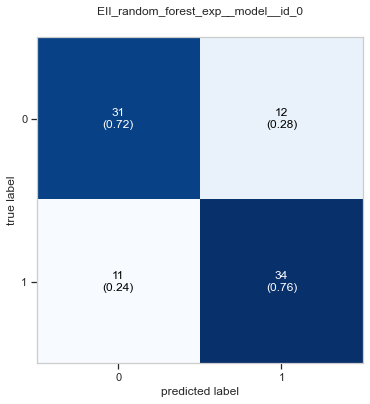

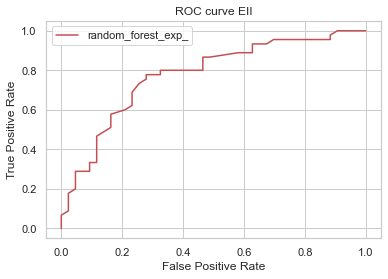

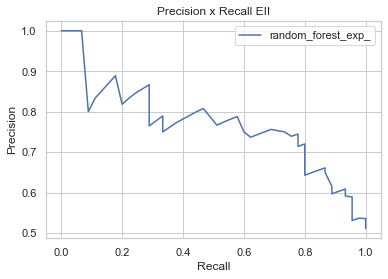


Classifier  _id_1
Computing metrics for  EII_random_forest_exp__model__id_1 model id  1
[[32 12]
 [15 29]]
tn: 32 fp: 12 fn: 15 tp: 29
LogLoss 0.5188
Balanced Accuracy 69.32%
Accuracy 69.32%
Precision 70.73%
Recall (Sensitivity) 65.91%
Specificity 68.09%
False Positive Rate 27.27%
False Negative Rate 34.09%
ROC AUC 81.04%
F1 68.24%


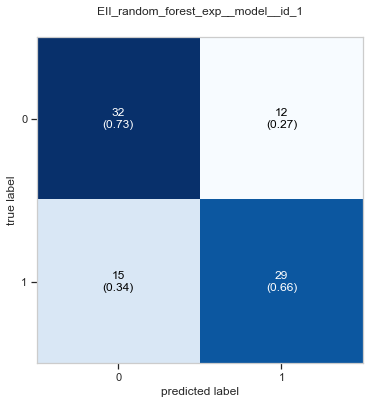

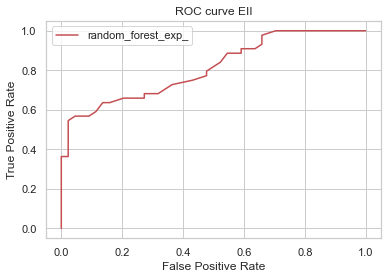

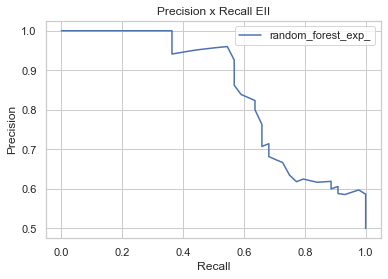


Classifier  _id_2
Computing metrics for  EII_random_forest_exp__model__id_2 model id  2
[[36  7]
 [16 28]]
tn: 36 fp: 7 fn: 16 tp: 28
LogLoss 0.531
Balanced Accuracy 73.68%
Accuracy 73.56%
Precision 80.00%
Recall (Sensitivity) 63.64%
Specificity 69.23%
False Positive Rate 16.28%
False Negative Rate 36.36%
ROC AUC 81.50%
F1 70.89%


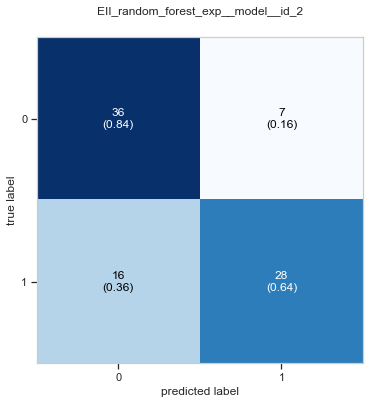

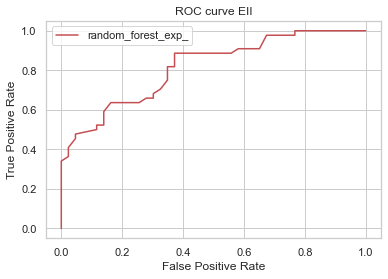

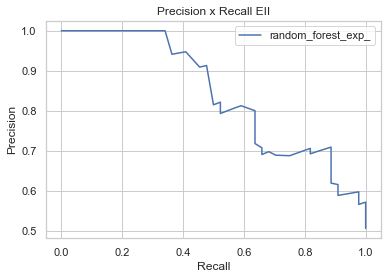


Classifier  _id_3
Computing metrics for  EII_random_forest_exp__model__id_3 model id  3
[[26 17]
 [ 8 37]]
tn: 26 fp: 17 fn: 8 tp: 37
LogLoss 0.5411
Balanced Accuracy 71.34%
Accuracy 71.59%
Precision 68.52%
Recall (Sensitivity) 82.22%
Specificity 76.47%
False Positive Rate 39.53%
False Negative Rate 17.78%
ROC AUC 80.70%
F1 74.75%


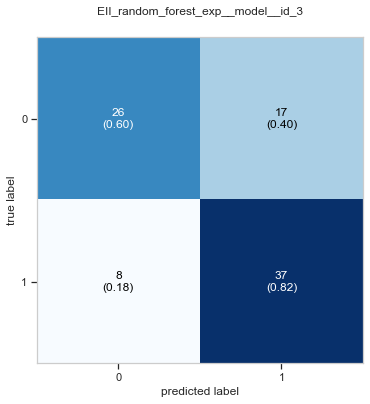

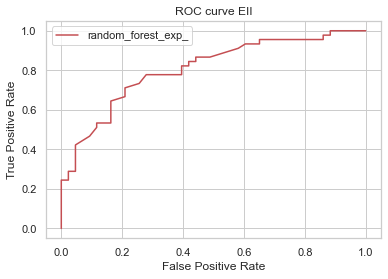

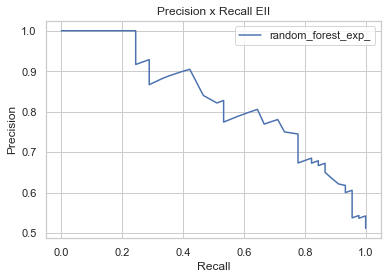


Classifier  _id_4
Computing metrics for  EII_random_forest_exp__model__id_4 model id  4
[[33 11]
 [18 26]]
tn: 33 fp: 11 fn: 18 tp: 26
LogLoss 0.5894
Balanced Accuracy 67.05%
Accuracy 67.05%
Precision 70.27%
Recall (Sensitivity) 59.09%
Specificity 64.71%
False Positive Rate 25.00%
False Negative Rate 40.91%
ROC AUC 72.29%
F1 64.20%


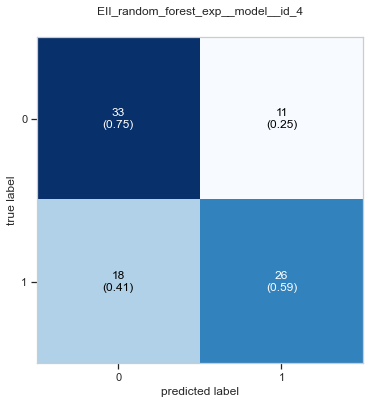

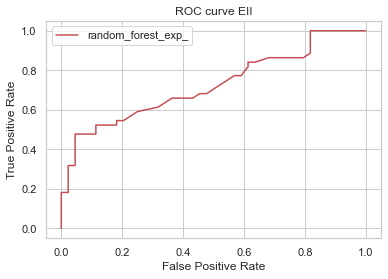

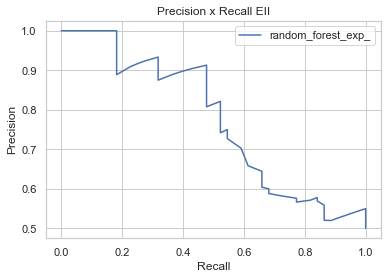


Classifier  _id_5
Computing metrics for  EII_random_forest_exp__model__id_5 model id  5
[[31 12]
 [13 31]]
tn: 31 fp: 12 fn: 13 tp: 31
LogLoss 0.5334
Balanced Accuracy 71.27%
Accuracy 71.26%
Precision 72.09%
Recall (Sensitivity) 70.45%
Specificity 70.45%
False Positive Rate 27.91%
False Negative Rate 29.55%
ROC AUC 81.08%
F1 71.26%


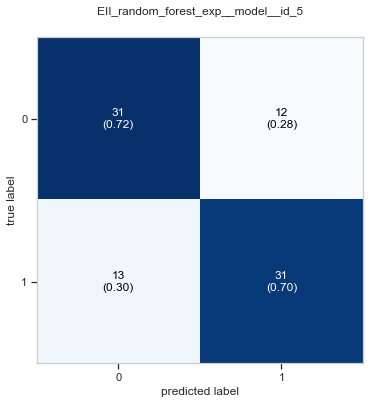

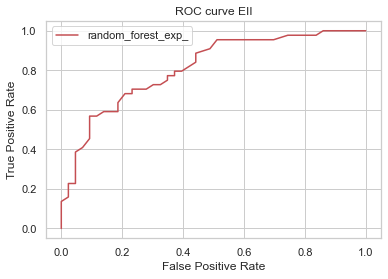

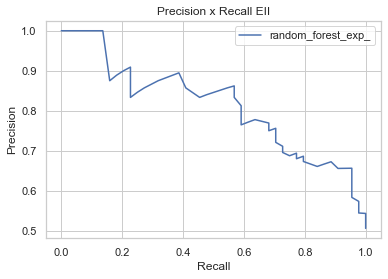


Classifier  _id_6
Computing metrics for  EII_random_forest_exp__model__id_6 model id  6
[[28 15]
 [11 34]]
tn: 28 fp: 15 fn: 11 tp: 34
LogLoss 0.5367
Balanced Accuracy 70.34%
Accuracy 70.45%
Precision 69.39%
Recall (Sensitivity) 75.56%
Specificity 71.79%
False Positive Rate 34.88%
False Negative Rate 24.44%
ROC AUC 80.36%
F1 72.34%


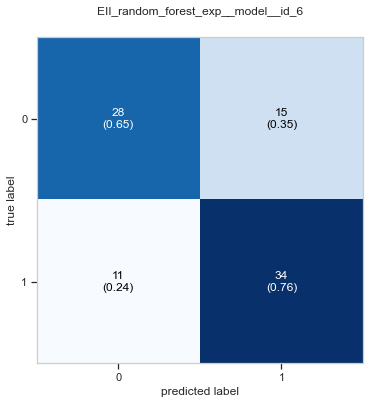

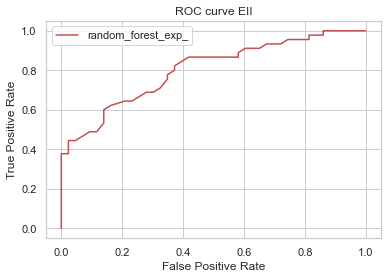

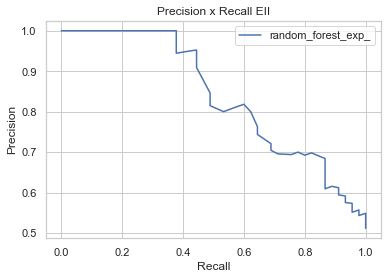


Classifier  _id_7
Computing metrics for  EII_random_forest_exp__model__id_7 model id  7
[[39  5]
 [16 28]]
tn: 39 fp: 5 fn: 16 tp: 28
LogLoss 0.5169
Balanced Accuracy 76.14%
Accuracy 76.14%
Precision 84.85%
Recall (Sensitivity) 63.64%
Specificity 70.91%
False Positive Rate 11.36%
False Negative Rate 36.36%
ROC AUC 81.30%
F1 72.73%


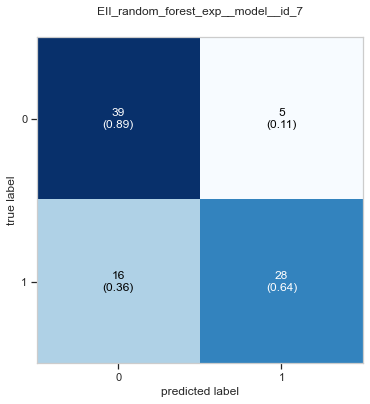

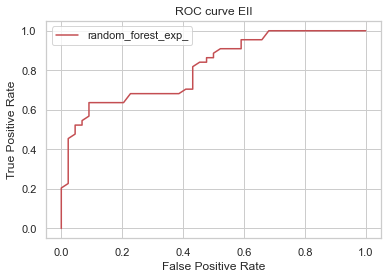

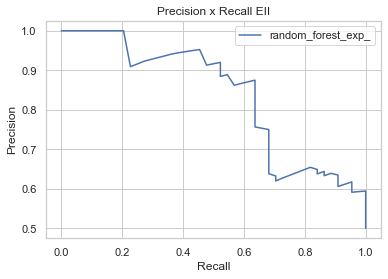


Classifier  _id_8
Computing metrics for  EII_random_forest_exp__model__id_8 model id  8
[[30 13]
 [14 30]]
tn: 30 fp: 13 fn: 14 tp: 30
LogLoss 0.6014
Balanced Accuracy 68.97%
Accuracy 68.97%
Precision 69.77%
Recall (Sensitivity) 68.18%
Specificity 68.18%
False Positive Rate 30.23%
False Negative Rate 31.82%
ROC AUC 74.60%
F1 68.97%


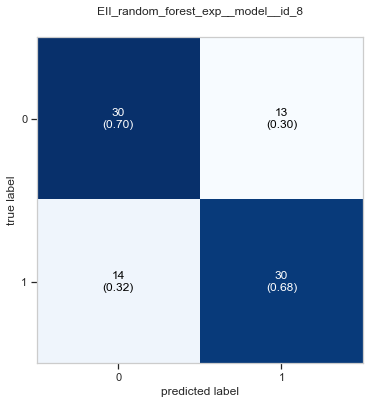

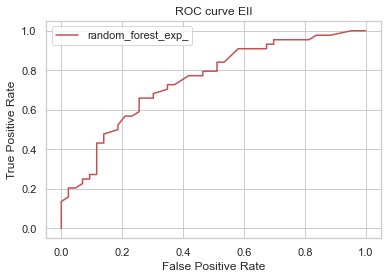

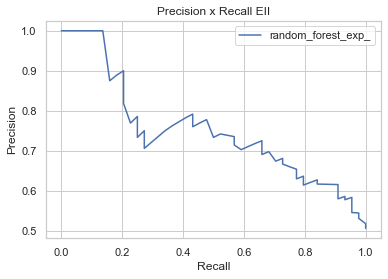

In [27]:
from sklearn.ensemble import RandomForestClassifier

experiment = "random_forest"

for exp_n in range(N_EXPERIMENTS):
    exp_train_x, exp_train_y, exp_valid_x, exp_valid_y = get_kfold(exp_n)
    model = RandomForestClassifier(random_state=42)
    model.fit(exp_train_x, exp_train_y)
    dump(model,EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(exp_n))
    #dump(model,EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(exp_n))
    
    #evaluate_classifier(experiment + '_exp_', exp_n, exp_valid_x, exp_valid_y , model, "_id_{}".format(exp_n))
    evaluate_classifier(experiment + '_exp_', exp_n, exp_valid_x, exp_valid_y , model, "_id_{}".format(exp_n))

In [28]:
#get_kfold(exp_n)

## Logistic Regression

Classifier  _id_0
Computing metrics for  EII_logistic_regression_exp__model__id_0 model id  0
[[27 16]
 [11 34]]
tn: 27 fp: 16 fn: 11 tp: 34
LogLoss 0.5532
Balanced Accuracy 69.17%
Accuracy 69.32%
Precision 68.00%
Recall (Sensitivity) 75.56%
Specificity 71.05%
False Positive Rate 37.21%
False Negative Rate 24.44%
ROC AUC 79.90%
F1 71.58%


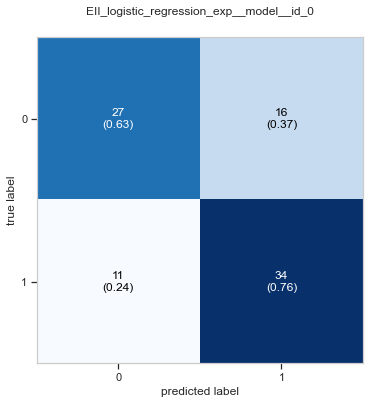

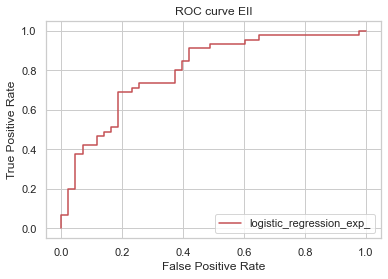

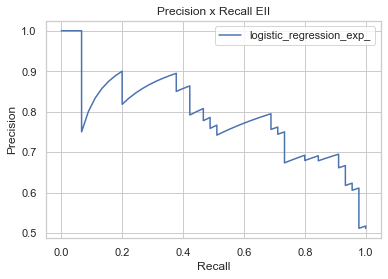


Classifier  _id_1
Computing metrics for  EII_logistic_regression_exp__model__id_1 model id  1
[[32 12]
 [14 30]]
tn: 32 fp: 12 fn: 14 tp: 30
LogLoss 0.5989
Balanced Accuracy 70.45%
Accuracy 70.45%
Precision 71.43%
Recall (Sensitivity) 68.18%
Specificity 69.57%
False Positive Rate 27.27%
False Negative Rate 31.82%
ROC AUC 75.46%
F1 69.77%


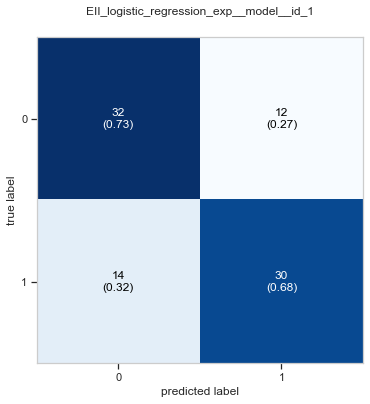

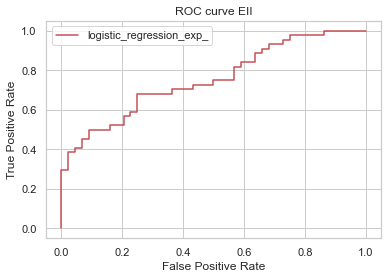

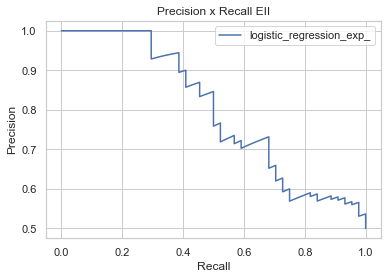


Classifier  _id_2
Computing metrics for  EII_logistic_regression_exp__model__id_2 model id  2
[[36  7]
 [17 27]]
tn: 36 fp: 7 fn: 17 tp: 27
LogLoss 0.591
Balanced Accuracy 72.54%
Accuracy 72.41%
Precision 79.41%
Recall (Sensitivity) 61.36%
Specificity 67.92%
False Positive Rate 16.28%
False Negative Rate 38.64%
ROC AUC 75.90%
F1 69.23%


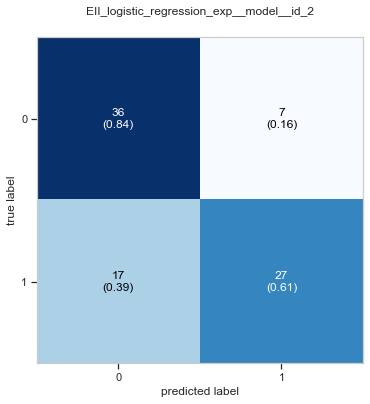

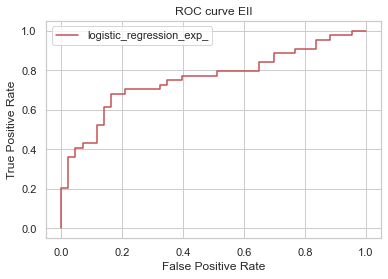

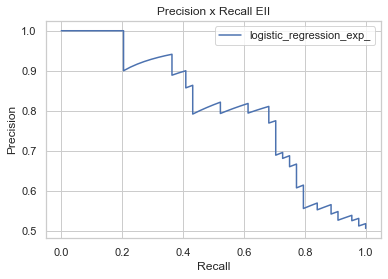


Classifier  _id_3
Computing metrics for  EII_logistic_regression_exp__model__id_3 model id  3
[[28 15]
 [10 35]]
tn: 28 fp: 15 fn: 10 tp: 35
LogLoss 0.5861
Balanced Accuracy 71.45%
Accuracy 71.59%
Precision 70.00%
Recall (Sensitivity) 77.78%
Specificity 73.68%
False Positive Rate 34.88%
False Negative Rate 22.22%
ROC AUC 78.76%
F1 73.68%


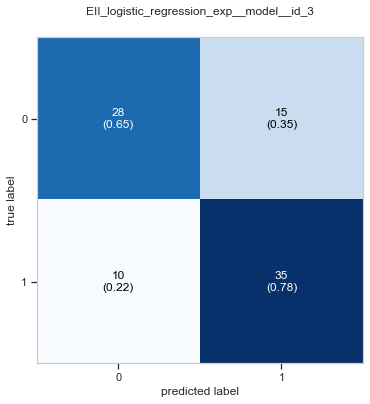

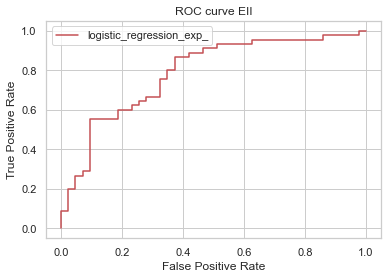

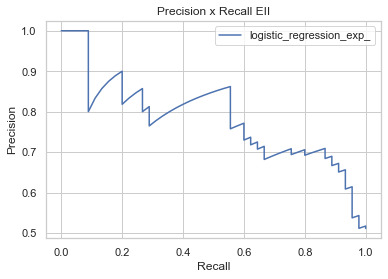


Classifier  _id_4
Computing metrics for  EII_logistic_regression_exp__model__id_4 model id  4
[[32 12]
 [19 25]]
tn: 32 fp: 12 fn: 19 tp: 25
LogLoss 0.6721
Balanced Accuracy 64.77%
Accuracy 64.77%
Precision 67.57%
Recall (Sensitivity) 56.82%
Specificity 62.75%
False Positive Rate 27.27%
False Negative Rate 43.18%
ROC AUC 68.80%
F1 61.73%


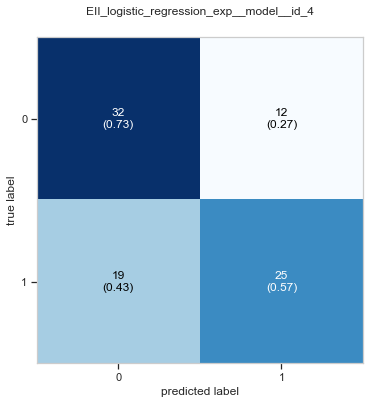

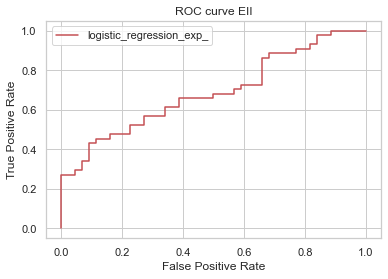

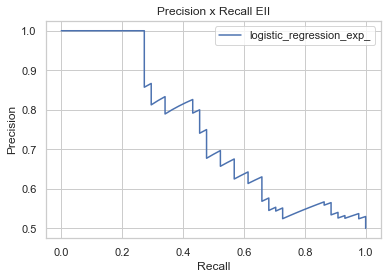


Classifier  _id_5
Computing metrics for  EII_logistic_regression_exp__model__id_5 model id  5
[[31 12]
 [13 31]]
tn: 31 fp: 12 fn: 13 tp: 31
LogLoss 0.5573
Balanced Accuracy 71.27%
Accuracy 71.26%
Precision 72.09%
Recall (Sensitivity) 70.45%
Specificity 70.45%
False Positive Rate 27.91%
False Negative Rate 29.55%
ROC AUC 80.23%
F1 71.26%


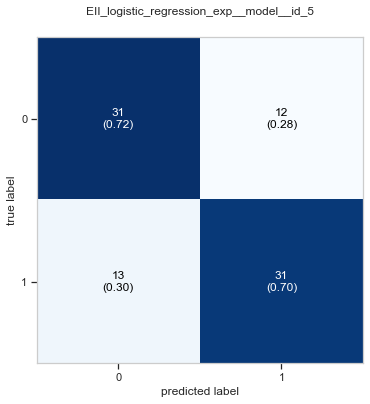

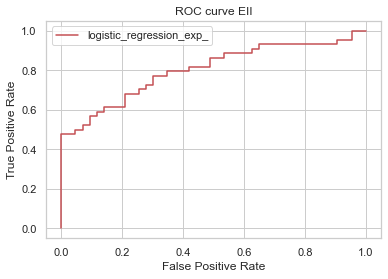

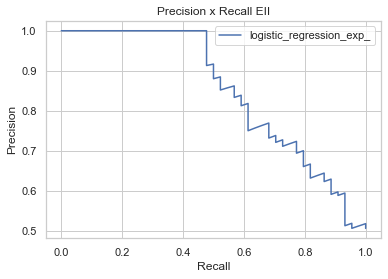


Classifier  _id_6
Computing metrics for  EII_logistic_regression_exp__model__id_6 model id  6
[[29 14]
 [11 34]]
tn: 29 fp: 14 fn: 11 tp: 34
LogLoss 0.5631
Balanced Accuracy 71.50%
Accuracy 71.59%
Precision 70.83%
Recall (Sensitivity) 75.56%
Specificity 72.50%
False Positive Rate 32.56%
False Negative Rate 24.44%
ROC AUC 80.62%
F1 73.12%


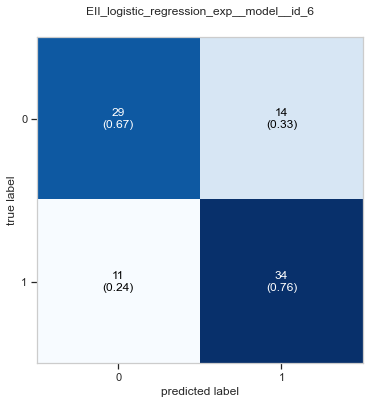

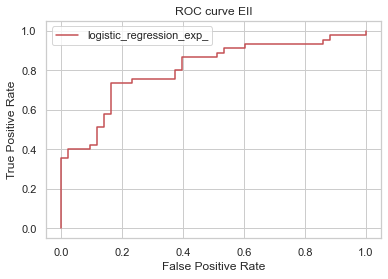

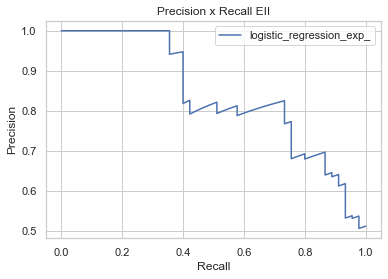


Classifier  _id_7
Computing metrics for  EII_logistic_regression_exp__model__id_7 model id  7
[[35  9]
 [20 24]]
tn: 35 fp: 9 fn: 20 tp: 24
LogLoss 0.5172
Balanced Accuracy 67.05%
Accuracy 67.05%
Precision 72.73%
Recall (Sensitivity) 54.55%
Specificity 63.64%
False Positive Rate 20.45%
False Negative Rate 45.45%
ROC AUC 81.66%
F1 62.34%


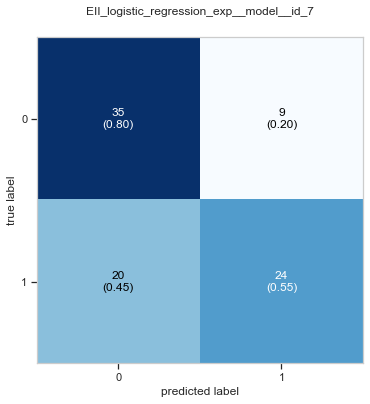

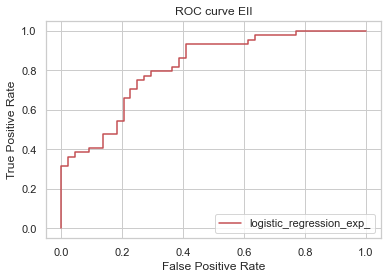

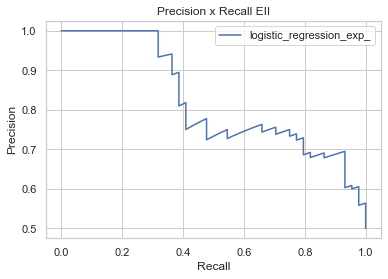


Classifier  _id_8
Computing metrics for  EII_logistic_regression_exp__model__id_8 model id  8
[[28 15]
 [12 32]]
tn: 28 fp: 15 fn: 12 tp: 32
LogLoss 0.6901
Balanced Accuracy 68.92%
Accuracy 68.97%
Precision 68.09%
Recall (Sensitivity) 72.73%
Specificity 70.00%
False Positive Rate 34.88%
False Negative Rate 27.27%
ROC AUC 73.63%
F1 70.33%


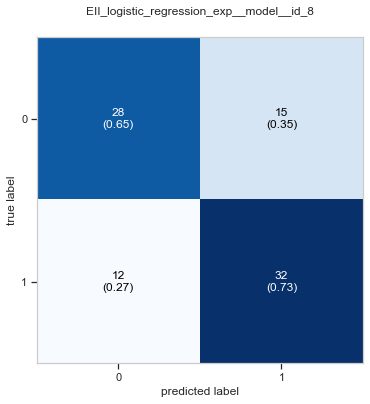

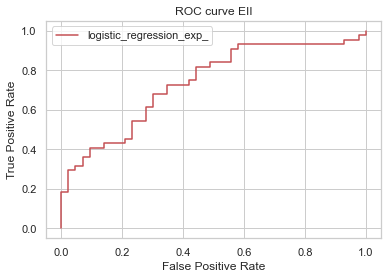

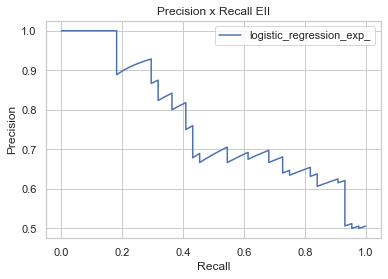

In [29]:
from sklearn.linear_model import LogisticRegression

experiment = "logistic_regression"

for exp_n in range(N_EXPERIMENTS):
    exp_train_x, exp_train_y, exp_valid_x, exp_valid_y = get_kfold(exp_n)
    model = LogisticRegression(random_state=42)
    model.fit(exp_train_x, exp_train_y)
    dump(model,EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(exp_n))
    
    evaluate_classifier(experiment + '_exp_', exp_n, exp_valid_x, exp_valid_y , model, "_id_{}".format(exp_n))

## XGBoost

In [30]:
#!pip install xgboost

Classifier  _id_0
Computing metrics for  EII_xgboost_exp__model__id_0 model id  0
[[30 13]
 [ 8 37]]
tn: 30 fp: 13 fn: 8 tp: 37
LogLoss 0.6377
Balanced Accuracy 75.99%
Accuracy 76.14%
Precision 74.00%
Recall (Sensitivity) 82.22%
Specificity 78.95%
False Positive Rate 30.23%
False Negative Rate 17.78%
ROC AUC 80.26%
F1 77.89%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


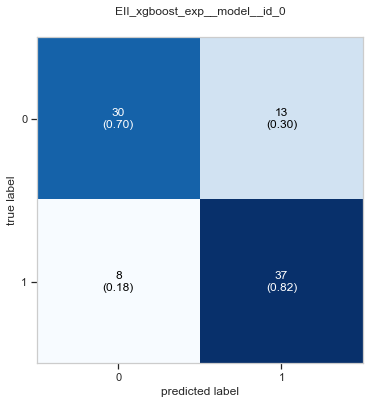

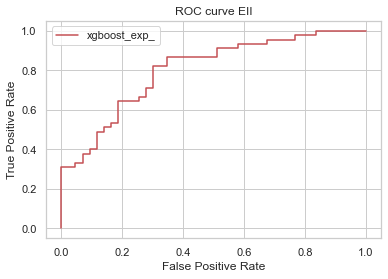

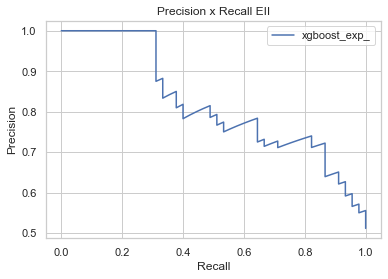


Classifier  _id_1
Computing metrics for  EII_xgboost_exp__model__id_1 model id  1
[[25 19]
 [17 27]]
tn: 25 fp: 19 fn: 17 tp: 27
LogLoss 0.9143
Balanced Accuracy 59.09%
Accuracy 59.09%
Precision 58.70%
Recall (Sensitivity) 61.36%
Specificity 59.52%
False Positive Rate 43.18%
False Negative Rate 38.64%
ROC AUC 74.79%
F1 60.00%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


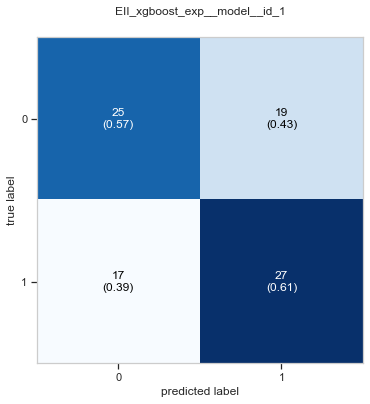

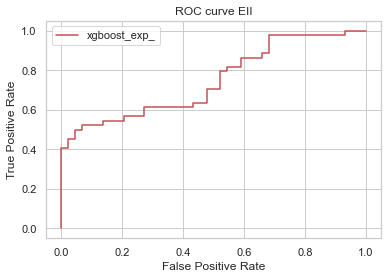

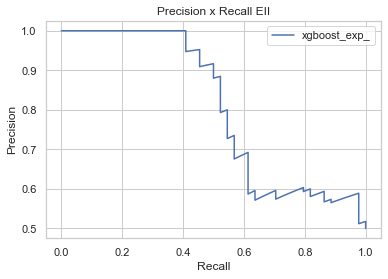


Classifier  _id_2
Computing metrics for  EII_xgboost_exp__model__id_2 model id  2
[[36  7]
 [19 25]]
tn: 36 fp: 7 fn: 19 tp: 25
LogLoss 0.7303
Balanced Accuracy 70.27%
Accuracy 70.11%
Precision 78.12%
Recall (Sensitivity) 56.82%
Specificity 65.45%
False Positive Rate 16.28%
False Negative Rate 43.18%
ROC AUC 76.43%
F1 65.79%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


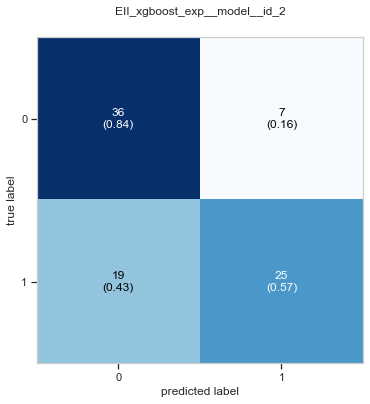

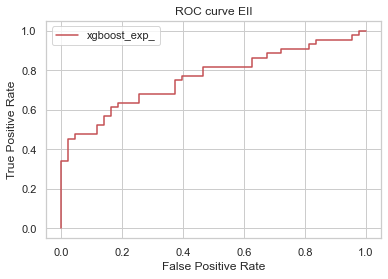

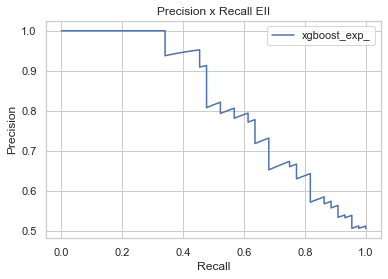


Classifier  _id_3
Computing metrics for  EII_xgboost_exp__model__id_3 model id  3
[[28 15]
 [13 32]]
tn: 28 fp: 15 fn: 13 tp: 32
LogLoss 0.7687
Balanced Accuracy 68.11%
Accuracy 68.18%
Precision 68.09%
Recall (Sensitivity) 71.11%
Specificity 68.29%
False Positive Rate 34.88%
False Negative Rate 28.89%
ROC AUC 76.12%
F1 69.57%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


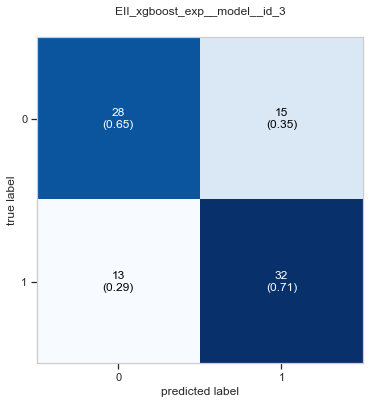

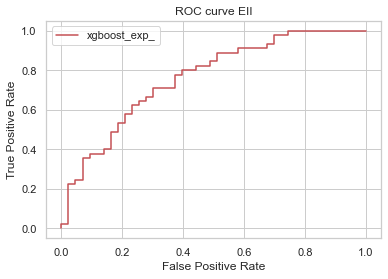

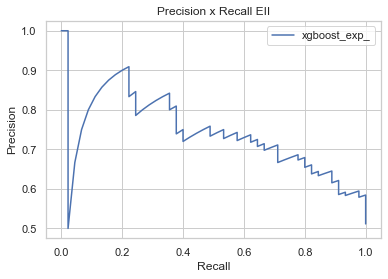


Classifier  _id_4
Computing metrics for  EII_xgboost_exp__model__id_4 model id  4
[[32 12]
 [19 25]]
tn: 32 fp: 12 fn: 19 tp: 25
LogLoss 0.8912
Balanced Accuracy 64.77%
Accuracy 64.77%
Precision 67.57%
Recall (Sensitivity) 56.82%
Specificity 62.75%
False Positive Rate 27.27%
False Negative Rate 43.18%
ROC AUC 70.76%
F1 61.73%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


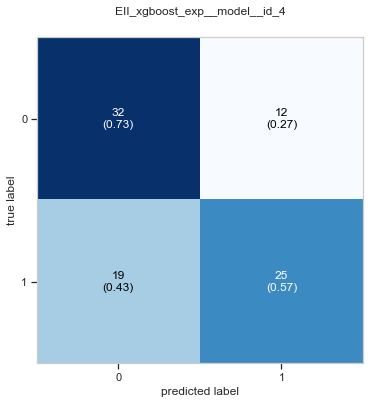

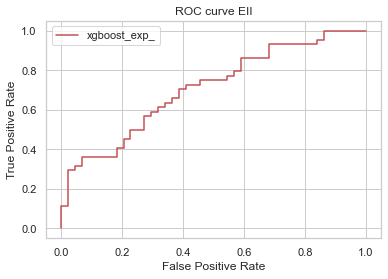

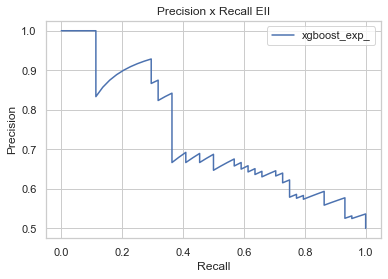


Classifier  _id_5
Computing metrics for  EII_xgboost_exp__model__id_5 model id  5
[[26 17]
 [12 32]]
tn: 26 fp: 17 fn: 12 tp: 32
LogLoss 0.7169
Balanced Accuracy 66.60%
Accuracy 66.67%
Precision 65.31%
Recall (Sensitivity) 72.73%
Specificity 68.42%
False Positive Rate 39.53%
False Negative Rate 27.27%
ROC AUC 78.44%
F1 68.82%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


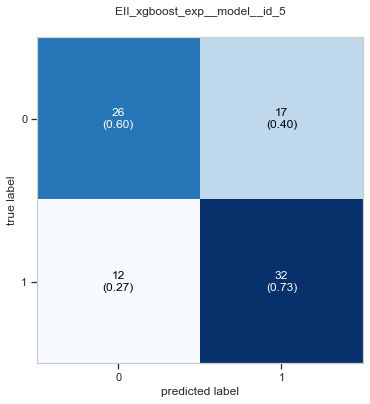

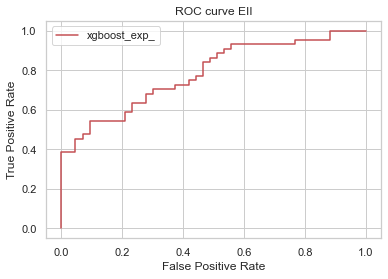

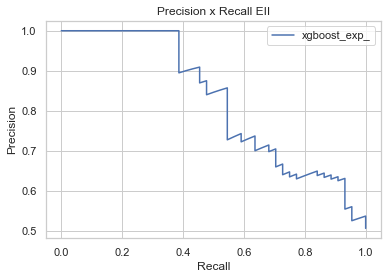


Classifier  _id_6
Computing metrics for  EII_xgboost_exp__model__id_6 model id  6
[[30 13]
 [14 31]]
tn: 30 fp: 13 fn: 14 tp: 31
LogLoss 0.7478
Balanced Accuracy 69.33%
Accuracy 69.32%
Precision 70.45%
Recall (Sensitivity) 68.89%
Specificity 68.18%
False Positive Rate 30.23%
False Negative Rate 31.11%
ROC AUC 76.12%
F1 69.66%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


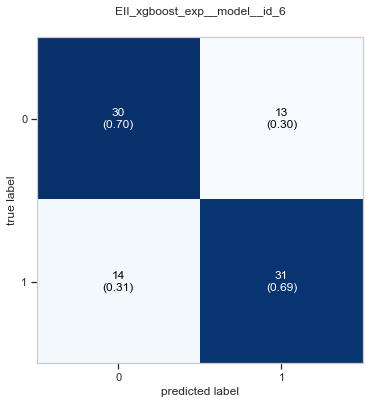

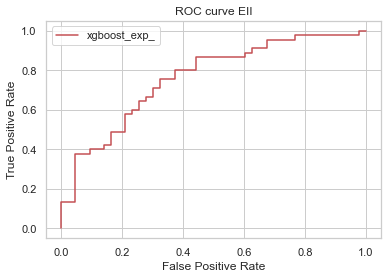

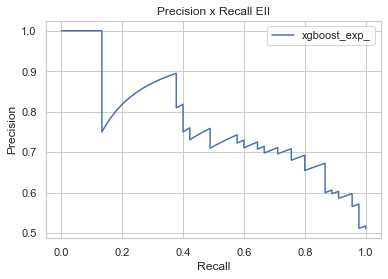


Classifier  _id_7
Computing metrics for  EII_xgboost_exp__model__id_7 model id  7
[[31 13]
 [13 31]]
tn: 31 fp: 13 fn: 13 tp: 31
LogLoss 0.6667
Balanced Accuracy 70.45%
Accuracy 70.45%
Precision 70.45%
Recall (Sensitivity) 70.45%
Specificity 70.45%
False Positive Rate 29.55%
False Negative Rate 29.55%
ROC AUC 79.60%
F1 70.45%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


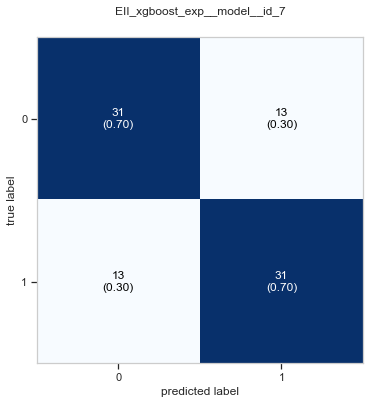

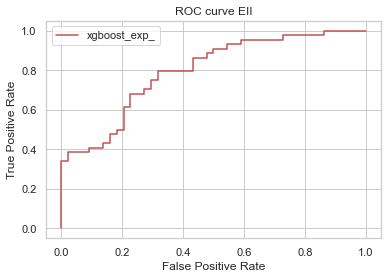

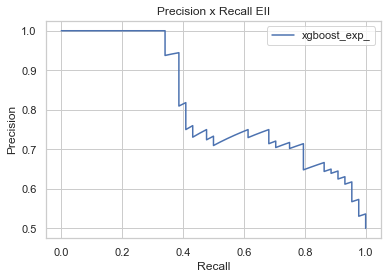


Classifier  _id_8
Computing metrics for  EII_xgboost_exp__model__id_8 model id  8
[[27 16]
 [11 33]]
tn: 27 fp: 16 fn: 11 tp: 33
LogLoss 0.7891
Balanced Accuracy 68.90%
Accuracy 68.97%
Precision 67.35%
Recall (Sensitivity) 75.00%
Specificity 71.05%
False Positive Rate 37.21%
False Negative Rate 25.00%
ROC AUC 74.79%
F1 70.97%


C:\Users\marta\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


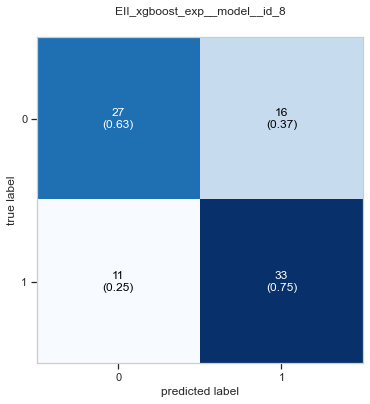

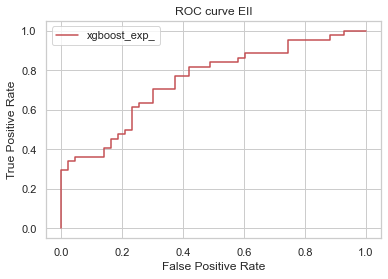

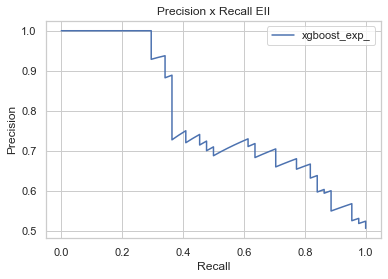

In [31]:
from xgboost import XGBClassifier

experiment = "xgboost"

for exp_n in range(N_EXPERIMENTS):
    exp_train_x, exp_train_y, exp_valid_x, exp_valid_y = get_kfold(exp_n)
    model = XGBClassifier(use_label_encoder=False, random_state=42)
    model.fit(exp_train_x, exp_train_y)
    dump(model,EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(exp_n))
    
    evaluate_classifier(experiment + '_exp_', exp_n, exp_valid_x, exp_valid_y , model, "_id_{}".format(exp_n))


## SVM

Classifier  _id_0
Computing metrics for  EII_svc_exp__model__id_0 model id  0
[[27 16]
 [11 34]]
tn: 27 fp: 16 fn: 11 tp: 34
LogLoss 0.5715
Balanced Accuracy 69.17%
Accuracy 69.32%
Precision 68.00%
Recall (Sensitivity) 75.56%
Specificity 71.05%
False Positive Rate 37.21%
False Negative Rate 24.44%
ROC AUC 76.23%
F1 71.58%


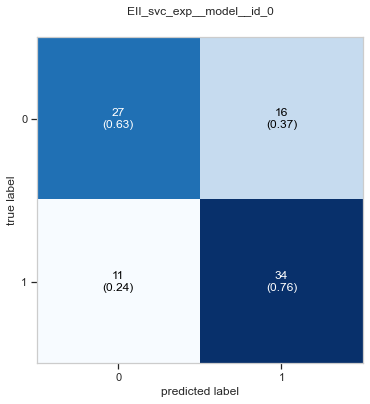

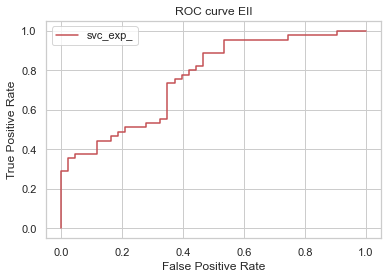

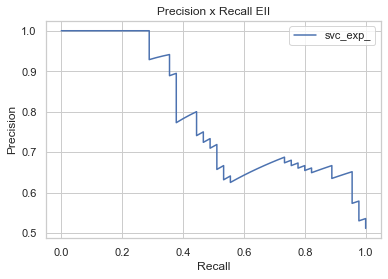


Classifier  _id_1
Computing metrics for  EII_svc_exp__model__id_1 model id  1
[[30 14]
 [13 31]]
tn: 30 fp: 14 fn: 13 tp: 31
LogLoss 0.5614
Balanced Accuracy 69.32%
Accuracy 69.32%
Precision 68.89%
Recall (Sensitivity) 70.45%
Specificity 69.77%
False Positive Rate 31.82%
False Negative Rate 29.55%
ROC AUC 76.91%
F1 69.66%


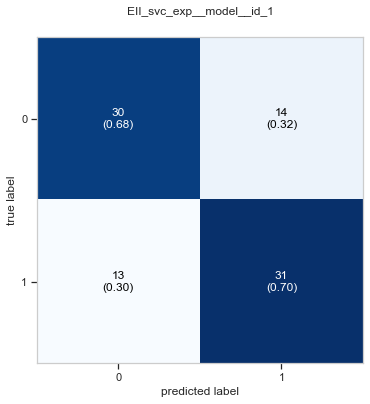

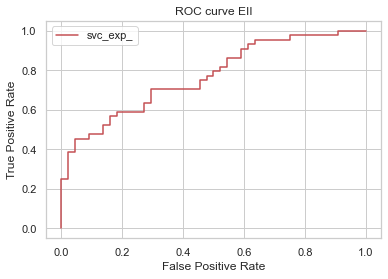

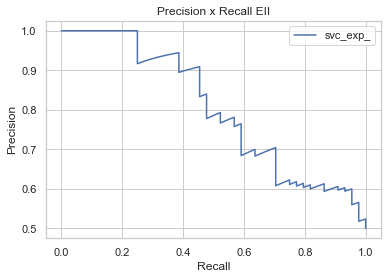


Classifier  _id_2
Computing metrics for  EII_svc_exp__model__id_2 model id  2
[[33 10]
 [15 29]]
tn: 33 fp: 10 fn: 15 tp: 29
LogLoss 0.5731
Balanced Accuracy 71.33%
Accuracy 71.26%
Precision 74.36%
Recall (Sensitivity) 65.91%
Specificity 68.75%
False Positive Rate 23.26%
False Negative Rate 34.09%
ROC AUC 77.27%
F1 69.88%


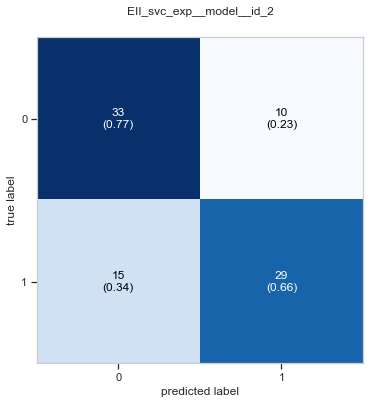

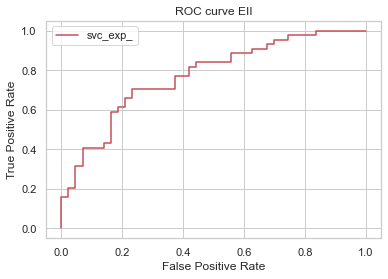

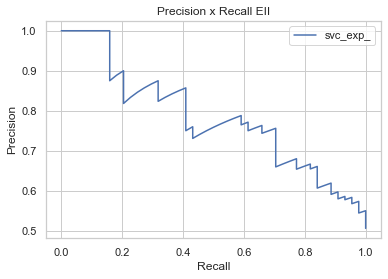


Classifier  _id_3
Computing metrics for  EII_svc_exp__model__id_3 model id  3
[[28 15]
 [ 8 37]]
tn: 28 fp: 15 fn: 8 tp: 37
LogLoss 0.5593
Balanced Accuracy 73.67%
Accuracy 73.86%
Precision 71.15%
Recall (Sensitivity) 82.22%
Specificity 77.78%
False Positive Rate 34.88%
False Negative Rate 17.78%
ROC AUC 79.02%
F1 76.29%


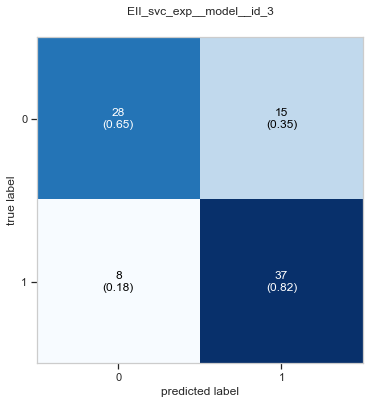

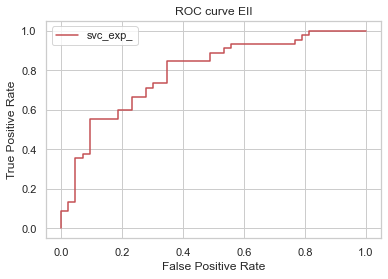

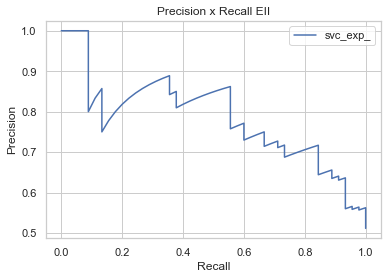


Classifier  _id_4
Computing metrics for  EII_svc_exp__model__id_4 model id  4
[[27 17]
 [13 31]]
tn: 27 fp: 17 fn: 13 tp: 31
LogLoss 0.6198
Balanced Accuracy 65.91%
Accuracy 65.91%
Precision 64.58%
Recall (Sensitivity) 70.45%
Specificity 67.50%
False Positive Rate 38.64%
False Negative Rate 29.55%
ROC AUC 70.20%
F1 67.39%


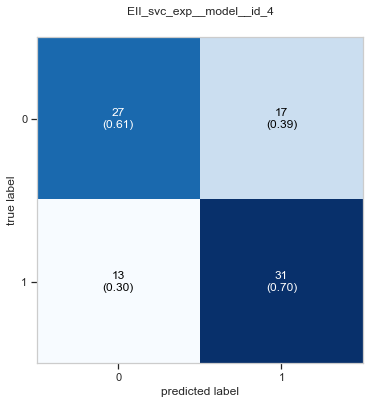

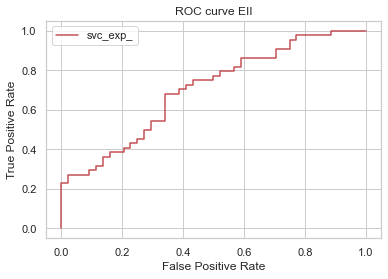

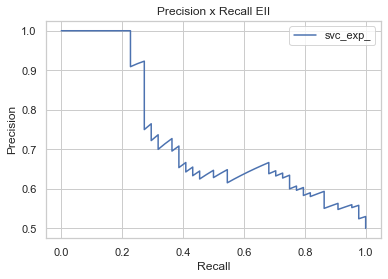


Classifier  _id_5
Computing metrics for  EII_svc_exp__model__id_5 model id  5
[[25 18]
 [11 33]]
tn: 25 fp: 18 fn: 11 tp: 33
LogLoss 0.5592
Balanced Accuracy 66.57%
Accuracy 66.67%
Precision 64.71%
Recall (Sensitivity) 75.00%
Specificity 69.44%
False Positive Rate 41.86%
False Negative Rate 25.00%
ROC AUC 78.91%
F1 69.47%


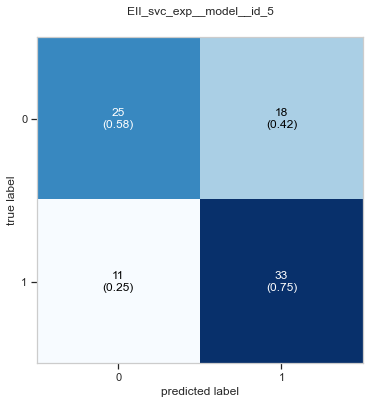

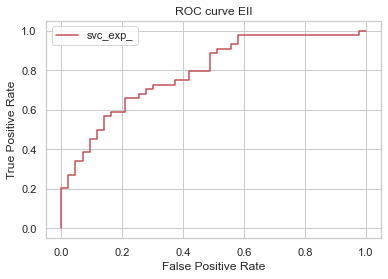

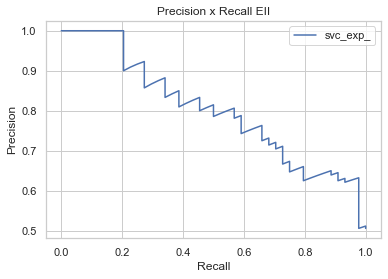


Classifier  _id_6
Computing metrics for  EII_svc_exp__model__id_6 model id  6
[[30 13]
 [ 9 36]]
tn: 30 fp: 13 fn: 9 tp: 36
LogLoss 0.5702
Balanced Accuracy 74.88%
Accuracy 75.00%
Precision 73.47%
Recall (Sensitivity) 80.00%
Specificity 76.92%
False Positive Rate 30.23%
False Negative Rate 20.00%
ROC AUC 80.05%
F1 76.60%


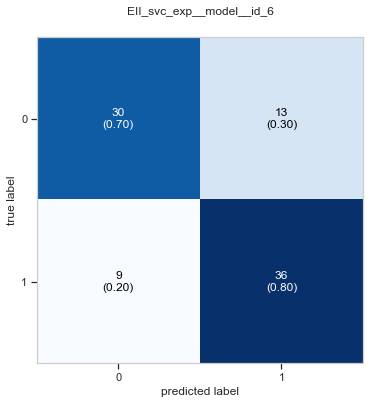

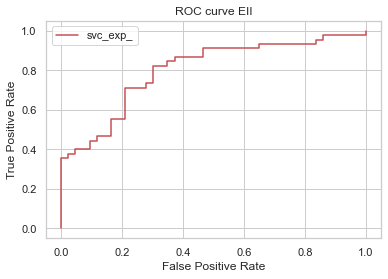

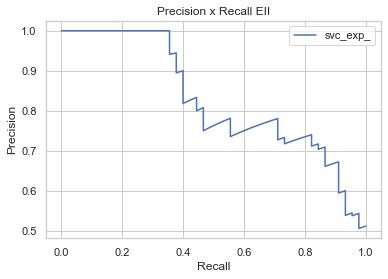


Classifier  _id_7
Computing metrics for  EII_svc_exp__model__id_7 model id  7
[[30 14]
 [14 30]]
tn: 30 fp: 14 fn: 14 tp: 30
LogLoss 0.5428
Balanced Accuracy 68.18%
Accuracy 68.18%
Precision 68.18%
Recall (Sensitivity) 68.18%
Specificity 68.18%
False Positive Rate 31.82%
False Negative Rate 31.82%
ROC AUC 79.96%
F1 68.18%


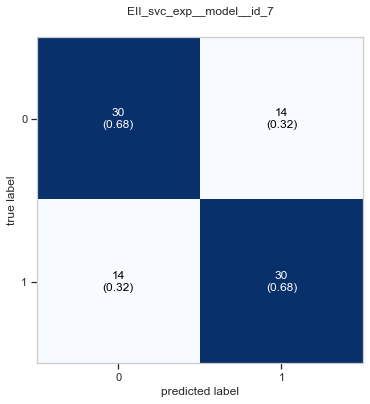

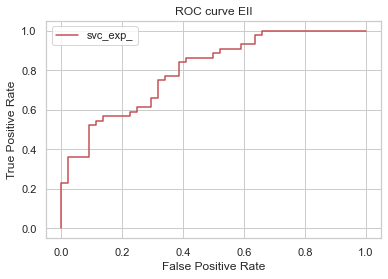

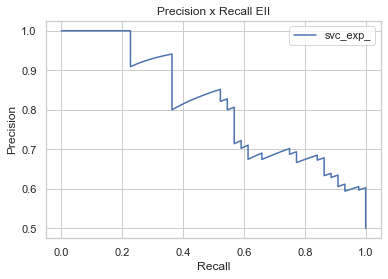


Classifier  _id_8
Computing metrics for  EII_svc_exp__model__id_8 model id  8
[[25 18]
 [13 31]]
tn: 25 fp: 18 fn: 13 tp: 31
LogLoss 0.6006
Balanced Accuracy 64.30%
Accuracy 64.37%
Precision 63.27%
Recall (Sensitivity) 70.45%
Specificity 65.79%
False Positive Rate 41.86%
False Negative Rate 29.55%
ROC AUC 74.10%
F1 66.67%


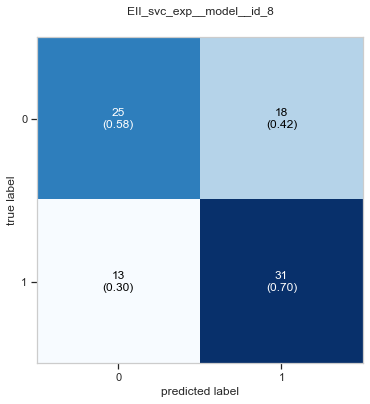

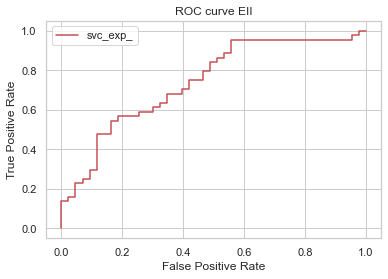

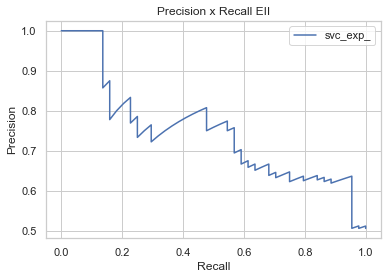

In [32]:
from sklearn.svm import SVC

experiment = "svc"

for exp_n in range(N_EXPERIMENTS):
    exp_train_x, exp_train_y, exp_valid_x, exp_valid_y = get_kfold(exp_n)
    model = SVC(kernel="linear", C=0.025, probability=True)
    model.fit(exp_train_x, exp_train_y)
    dump(model,EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(exp_n))
    
    evaluate_classifier(experiment + '_exp_', exp_n, exp_valid_x, exp_valid_y , model, "_id_{}".format(exp_n))

## Decision Tree

Classifier  _id_0
Computing metrics for  EII_dt_exp__model__id_0 model id  0
[[29 14]
 [12 33]]
tn: 29 fp: 14 fn: 12 tp: 33
LogLoss 3.101
Balanced Accuracy 70.39%
Accuracy 70.45%
Precision 70.21%
Recall (Sensitivity) 73.33%
Specificity 70.73%
False Positive Rate 32.56%
False Negative Rate 26.67%
ROC AUC 76.12%
F1 71.74%


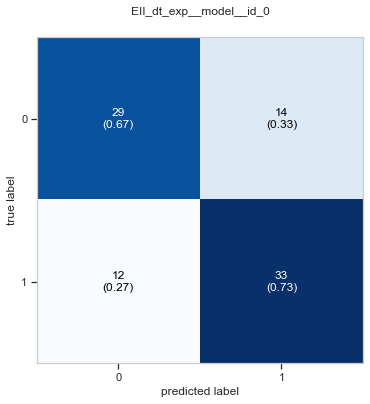

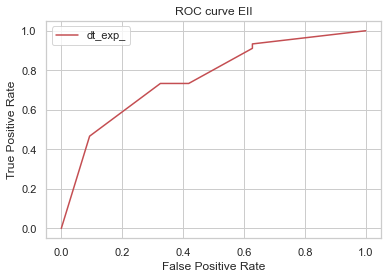

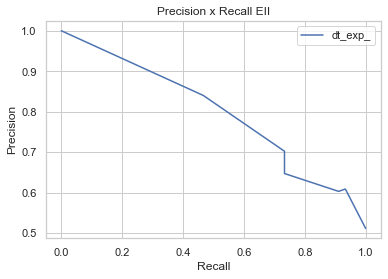


Classifier  _id_1
Computing metrics for  EII_dt_exp__model__id_1 model id  1
[[39  5]
 [22 22]]
tn: 39 fp: 5 fn: 22 tp: 22
LogLoss 1.305
Balanced Accuracy 69.32%
Accuracy 69.32%
Precision 81.48%
Recall (Sensitivity) 50.00%
Specificity 63.93%
False Positive Rate 11.36%
False Negative Rate 50.00%
ROC AUC 77.79%
F1 61.97%


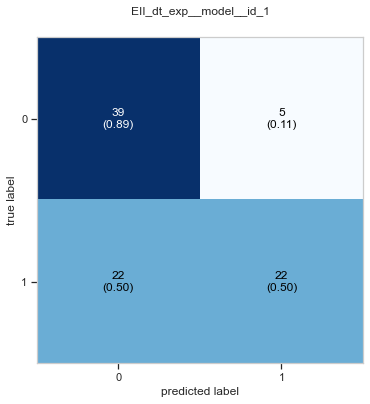

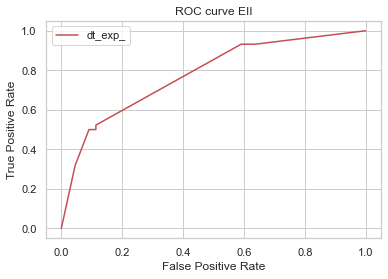

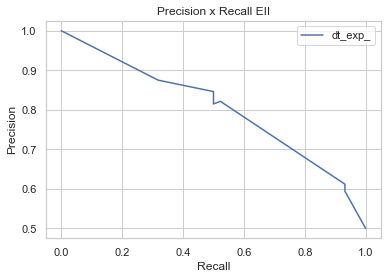


Classifier  _id_2
Computing metrics for  EII_dt_exp__model__id_2 model id  2
[[28 15]
 [19 25]]
tn: 28 fp: 15 fn: 19 tp: 25
LogLoss 2.502
Balanced Accuracy 60.97%
Accuracy 60.92%
Precision 62.50%
Recall (Sensitivity) 56.82%
Specificity 59.57%
False Positive Rate 34.88%
False Negative Rate 43.18%
ROC AUC 70.22%
F1 59.52%


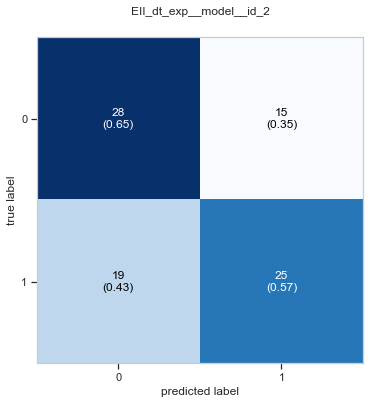

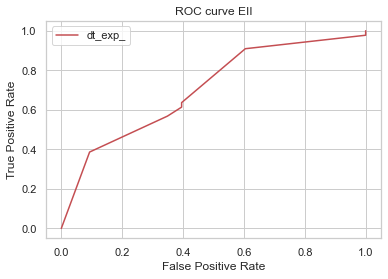

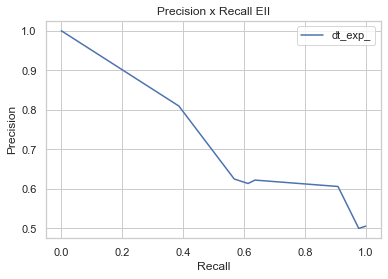


Classifier  _id_3
Computing metrics for  EII_dt_exp__model__id_3 model id  3
[[36  7]
 [23 22]]
tn: 36 fp: 7 fn: 23 tp: 22
LogLoss 3.511
Balanced Accuracy 66.30%
Accuracy 65.91%
Precision 75.86%
Recall (Sensitivity) 48.89%
Specificity 61.02%
False Positive Rate 16.28%
False Negative Rate 51.11%
ROC AUC 73.62%
F1 59.46%


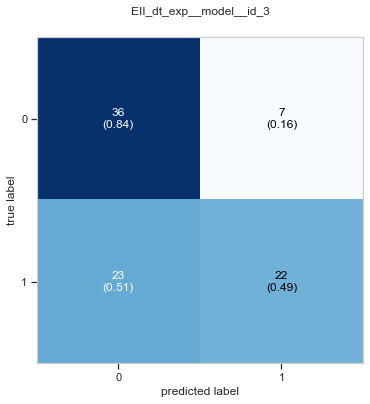

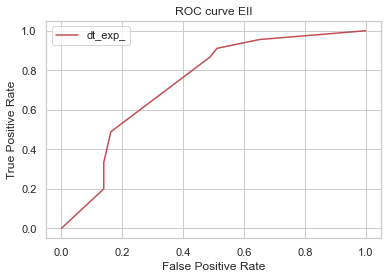

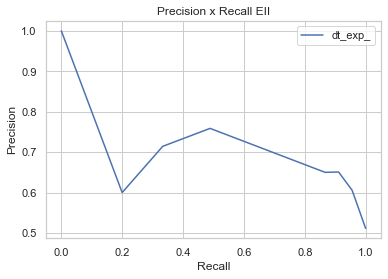


Classifier  _id_4
Computing metrics for  EII_dt_exp__model__id_4 model id  4
[[24 20]
 [12 32]]
tn: 24 fp: 20 fn: 12 tp: 32
LogLoss 4.337
Balanced Accuracy 63.64%
Accuracy 63.64%
Precision 61.54%
Recall (Sensitivity) 72.73%
Specificity 66.67%
False Positive Rate 45.45%
False Negative Rate 27.27%
ROC AUC 68.90%
F1 66.67%


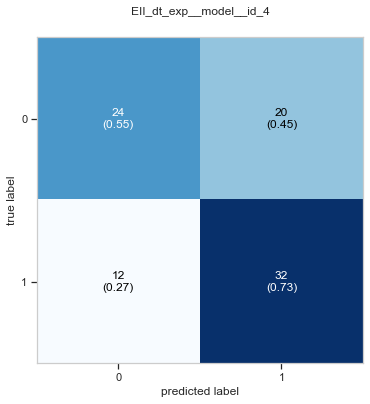

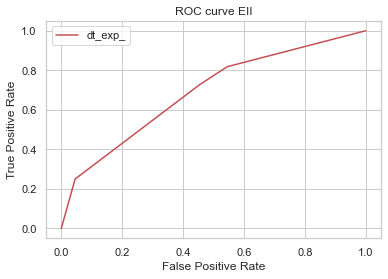

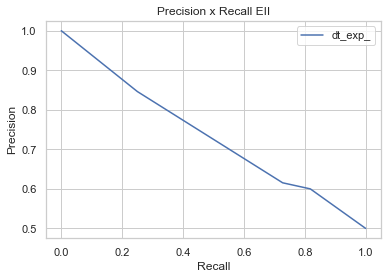


Classifier  _id_5
Computing metrics for  EII_dt_exp__model__id_5 model id  5
[[28 15]
 [ 9 35]]
tn: 28 fp: 15 fn: 9 tp: 35
LogLoss 2.363
Balanced Accuracy 72.33%
Accuracy 72.41%
Precision 70.00%
Recall (Sensitivity) 79.55%
Specificity 75.68%
False Positive Rate 34.88%
False Negative Rate 20.45%
ROC AUC 79.52%
F1 74.47%


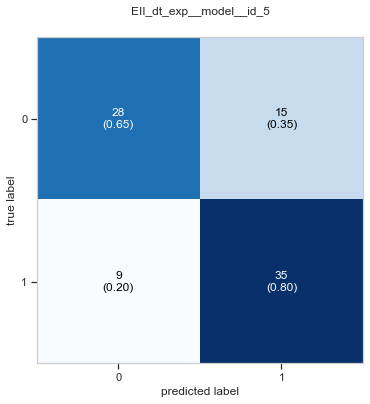

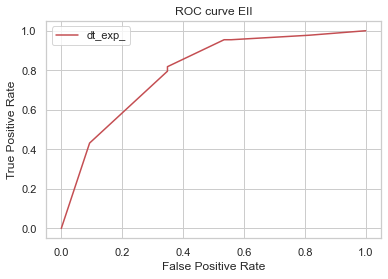

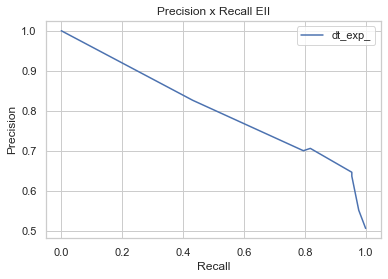


Classifier  _id_6
Computing metrics for  EII_dt_exp__model__id_6 model id  6
[[38  5]
 [24 21]]
tn: 38 fp: 5 fn: 24 tp: 21
LogLoss 2.77
Balanced Accuracy 67.52%
Accuracy 67.05%
Precision 80.77%
Recall (Sensitivity) 46.67%
Specificity 61.29%
False Positive Rate 11.63%
False Negative Rate 53.33%
ROC AUC 74.99%
F1 59.15%


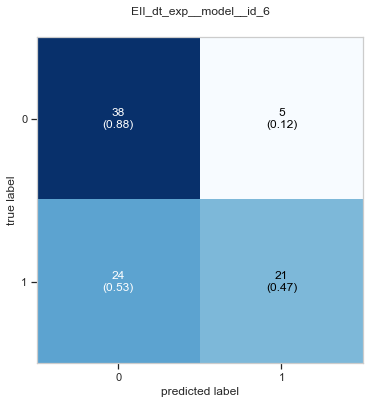

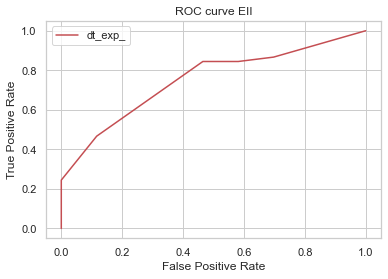

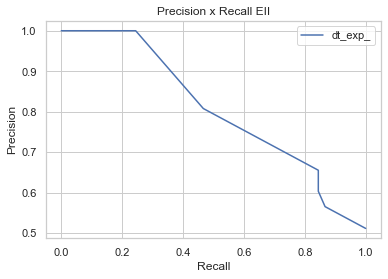


Classifier  _id_7
Computing metrics for  EII_dt_exp__model__id_7 model id  7
[[17 27]
 [ 9 35]]
tn: 17 fp: 27 fn: 9 tp: 35
LogLoss 4.748
Balanced Accuracy 59.09%
Accuracy 59.09%
Precision 56.45%
Recall (Sensitivity) 79.55%
Specificity 65.38%
False Positive Rate 61.36%
False Negative Rate 20.45%
ROC AUC 62.63%
F1 66.04%


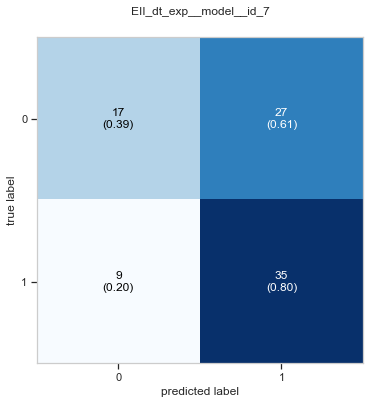

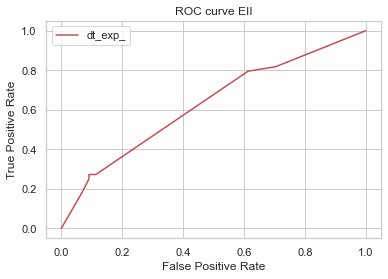

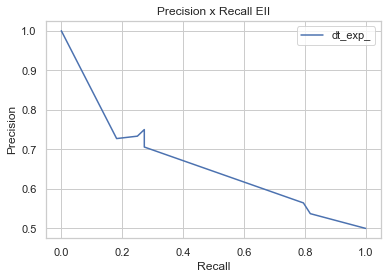


Classifier  _id_8
Computing metrics for  EII_dt_exp__model__id_8 model id  8
[[27 16]
 [ 8 36]]
tn: 27 fp: 16 fn: 8 tp: 36
LogLoss 3.872
Balanced Accuracy 72.30%
Accuracy 72.41%
Precision 69.23%
Recall (Sensitivity) 81.82%
Specificity 77.14%
False Positive Rate 37.21%
False Negative Rate 18.18%
ROC AUC 77.88%
F1 75.00%


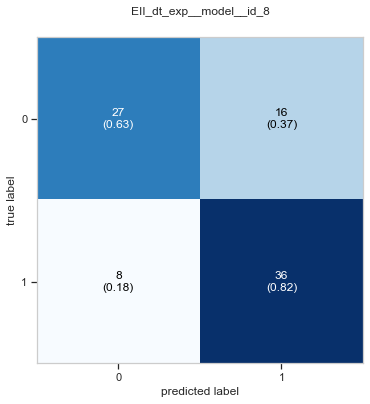

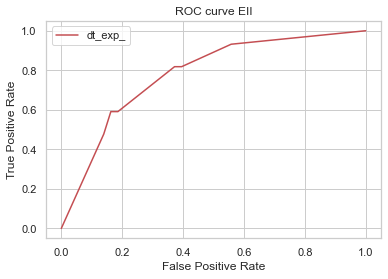

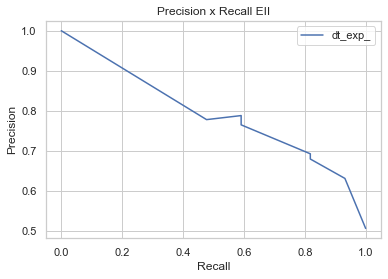

In [33]:
from sklearn.tree import DecisionTreeClassifier

experiment = "dt"

for exp_n in range(N_EXPERIMENTS):
    exp_train_x, exp_train_y, exp_valid_x, exp_valid_y = get_kfold(exp_n)
    model = DecisionTreeClassifier(max_depth=5)
    model.fit(exp_train_x, exp_train_y)
    dump(model,EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(exp_n))
    
    evaluate_classifier(experiment + '_exp_', exp_n, exp_valid_x, exp_valid_y , model, "_id_{}".format(exp_n))

## GaussianNB

Classifier  _id_0
Computing metrics for  EII_gaussian_nb_exp__model__id_0 model id  0
[[41  2]
 [35 10]]
tn: 41 fp: 2 fn: 35 tp: 10
LogLoss 13.58
Balanced Accuracy 58.79%
Accuracy 57.95%
Precision 83.33%
Recall (Sensitivity) 22.22%
Specificity 53.95%
False Positive Rate 4.65%
False Negative Rate 77.78%
ROC AUC 75.30%
F1 35.09%


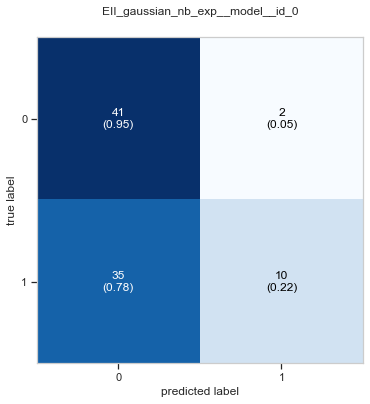

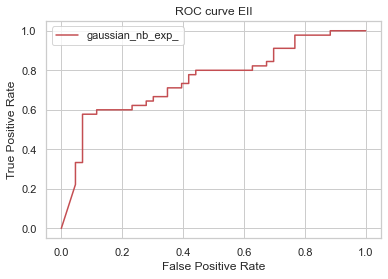

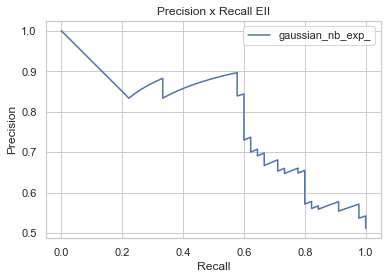


Classifier  _id_1
Computing metrics for  EII_gaussian_nb_exp__model__id_1 model id  1
[[38  6]
 [27 17]]
tn: 38 fp: 6 fn: 27 tp: 17
LogLoss 7.577
Balanced Accuracy 62.50%
Accuracy 62.50%
Precision 73.91%
Recall (Sensitivity) 38.64%
Specificity 58.46%
False Positive Rate 13.64%
False Negative Rate 61.36%
ROC AUC 71.28%
F1 50.75%


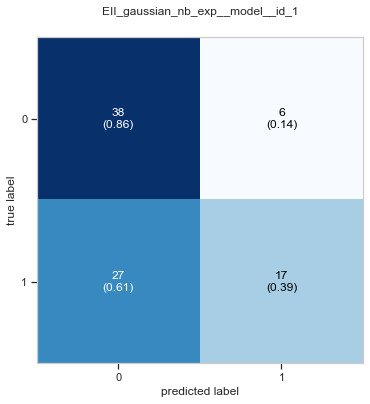

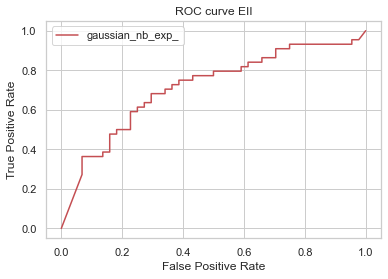

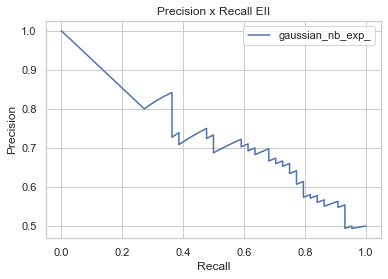


Classifier  _id_2
Computing metrics for  EII_gaussian_nb_exp__model__id_2 model id  2
[[40  3]
 [28 16]]
tn: 40 fp: 3 fn: 28 tp: 16
LogLoss 8.333
Balanced Accuracy 64.69%
Accuracy 64.37%
Precision 84.21%
Recall (Sensitivity) 36.36%
Specificity 58.82%
False Positive Rate 6.98%
False Negative Rate 63.64%
ROC AUC 69.42%
F1 50.79%


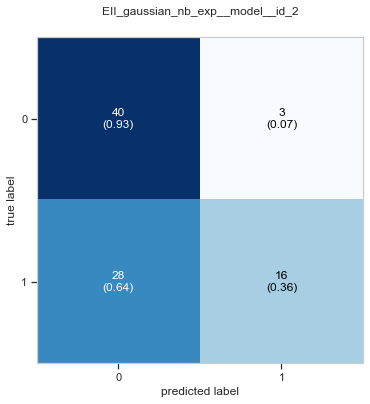

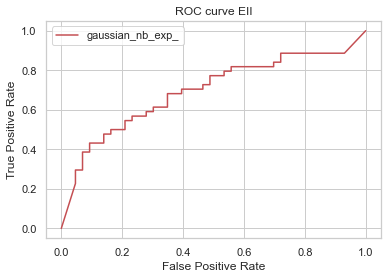

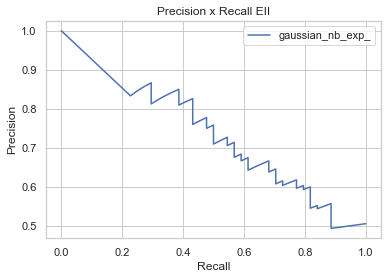


Classifier  _id_3
Computing metrics for  EII_gaussian_nb_exp__model__id_3 model id  3
[[41  2]
 [30 15]]
tn: 41 fp: 2 fn: 30 tp: 15
LogLoss 10.5
Balanced Accuracy 64.34%
Accuracy 63.64%
Precision 88.24%
Recall (Sensitivity) 33.33%
Specificity 57.75%
False Positive Rate 4.65%
False Negative Rate 66.67%
ROC AUC 80.90%
F1 48.39%


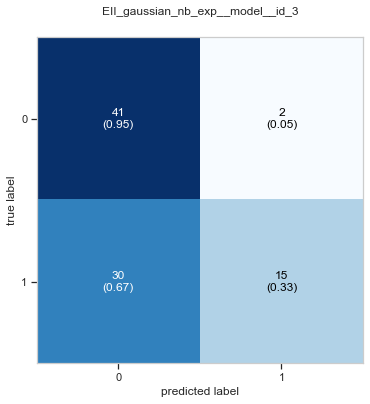

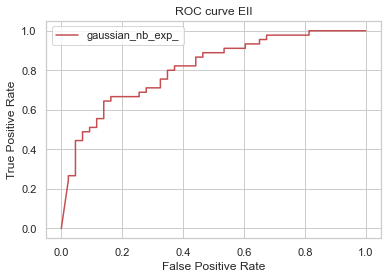

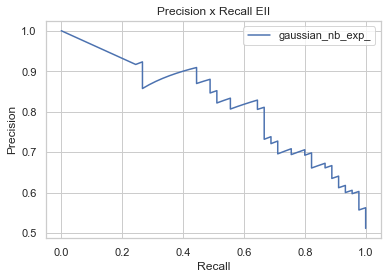


Classifier  _id_4
Computing metrics for  EII_gaussian_nb_exp__model__id_4 model id  4
[[40  4]
 [30 14]]
tn: 40 fp: 4 fn: 30 tp: 14
LogLoss 8.909
Balanced Accuracy 61.36%
Accuracy 61.36%
Precision 77.78%
Recall (Sensitivity) 31.82%
Specificity 57.14%
False Positive Rate 9.09%
False Negative Rate 68.18%
ROC AUC 65.16%
F1 45.16%


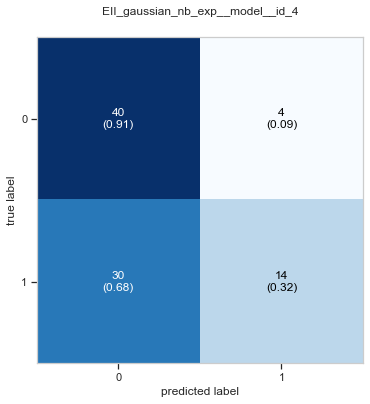

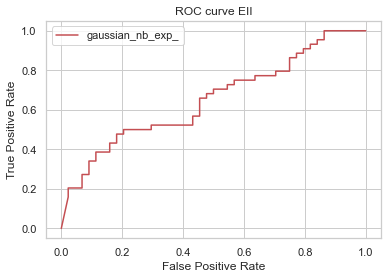

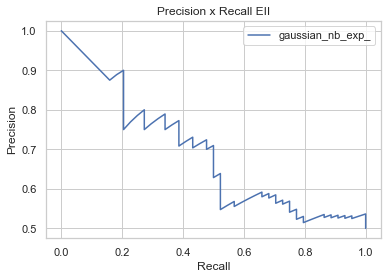


Classifier  _id_5
Computing metrics for  EII_gaussian_nb_exp__model__id_5 model id  5
[[42  1]
 [27 17]]
tn: 42 fp: 1 fn: 27 tp: 17
LogLoss 9.712
Balanced Accuracy 68.16%
Accuracy 67.82%
Precision 94.44%
Recall (Sensitivity) 38.64%
Specificity 60.87%
False Positive Rate 2.33%
False Negative Rate 61.36%
ROC AUC 82.43%
F1 54.84%


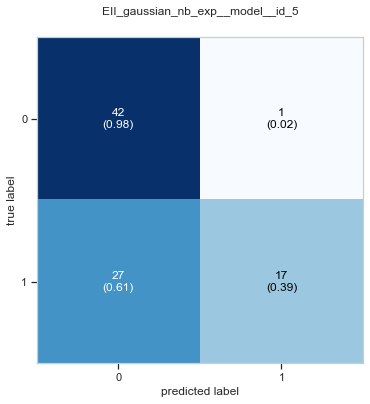

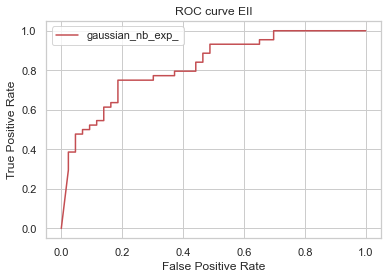

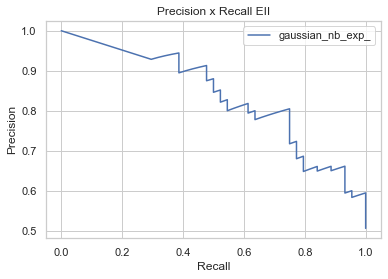


Classifier  _id_6
Computing metrics for  EII_gaussian_nb_exp__model__id_6 model id  6
[[40  3]
 [25 20]]
tn: 40 fp: 3 fn: 25 tp: 20
LogLoss 6.6
Balanced Accuracy 68.73%
Accuracy 68.18%
Precision 86.96%
Recall (Sensitivity) 44.44%
Specificity 61.54%
False Positive Rate 6.98%
False Negative Rate 55.56%
ROC AUC 73.62%
F1 58.82%


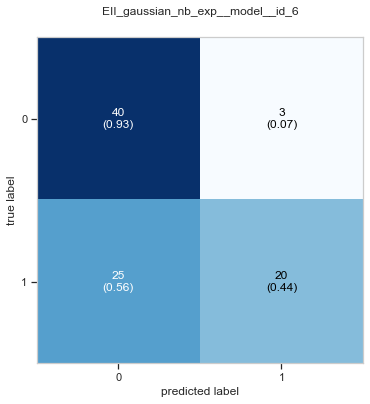

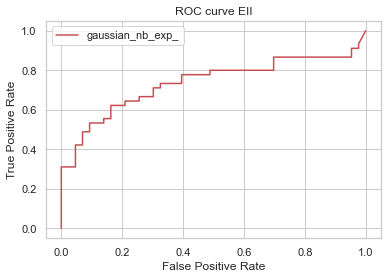

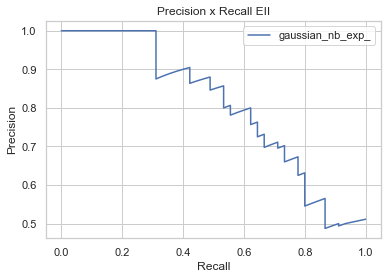


Classifier  _id_7
Computing metrics for  EII_gaussian_nb_exp__model__id_7 model id  7
[[42  2]
 [28 16]]
tn: 42 fp: 2 fn: 28 tp: 16
LogLoss 6.635
Balanced Accuracy 65.91%
Accuracy 65.91%
Precision 88.89%
Recall (Sensitivity) 36.36%
Specificity 60.00%
False Positive Rate 4.55%
False Negative Rate 63.64%
ROC AUC 67.36%
F1 51.61%


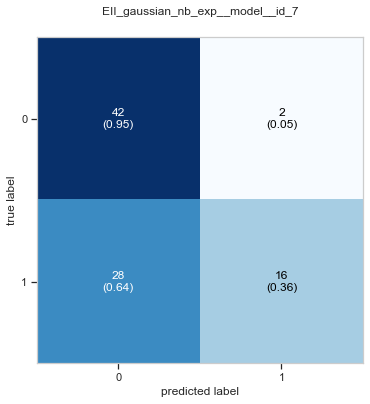

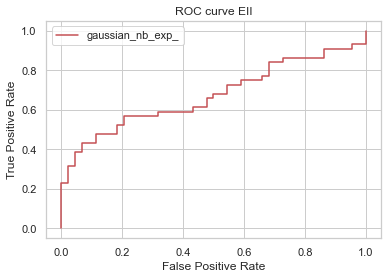

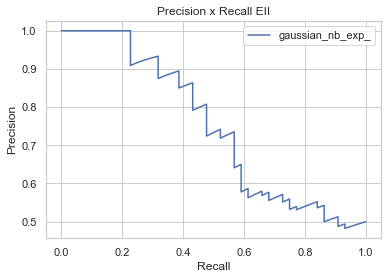


Classifier  _id_8
Computing metrics for  EII_gaussian_nb_exp__model__id_8 model id  8
[[38  5]
 [31 13]]
tn: 38 fp: 5 fn: 31 tp: 13
LogLoss 13.65
Balanced Accuracy 58.96%
Accuracy 58.62%
Precision 72.22%
Recall (Sensitivity) 29.55%
Specificity 55.07%
False Positive Rate 11.63%
False Negative Rate 70.45%
ROC AUC 72.44%
F1 41.94%


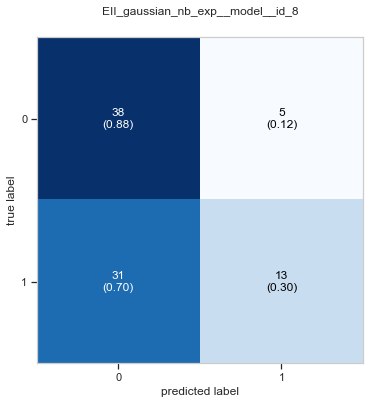

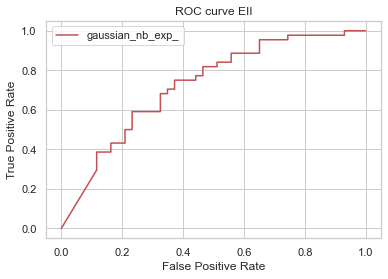

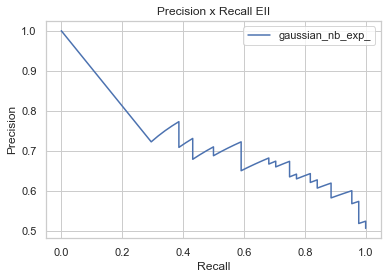

In [34]:
from sklearn.naive_bayes import GaussianNB

experiment = "gaussian_nb"

for exp_n in range(N_EXPERIMENTS):
    exp_train_x, exp_train_y, exp_valid_x, exp_valid_y = get_kfold(exp_n)
    model = GaussianNB()
    model.fit(exp_train_x, exp_train_y)
    dump(model,EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(exp_n))
    
    evaluate_classifier(experiment + '_exp_', exp_n, exp_valid_x, exp_valid_y , model, "_id_{}".format(exp_n))

In [35]:
pd.set_option('display.max_rows', 500)
metrics_df = pd.read_csv(EXPERIMENT_DIR + DATASET_NAME + "_metrics_df.csv", index_col=0)
metrics_df

model_id    tn    fp    fn    tp  \
EII_random_forest_exp__model__id_0             0.0  31.0  12.0  11.0  34.0   
EII_random_forest_exp__model__id_1             1.0  32.0  12.0  15.0  29.0   
EII_random_forest_exp__model__id_2             2.0  36.0   7.0  16.0  28.0   
EII_random_forest_exp__model__id_3             3.0  26.0  17.0   8.0  37.0   
EII_random_forest_exp__model__id_4             4.0  33.0  11.0  18.0  26.0   
EII_random_forest_exp__model__id_5             5.0  31.0  12.0  13.0  31.0   
EII_random_forest_exp__model__id_6             6.0  28.0  15.0  11.0  34.0   
EII_random_forest_exp__model__id_7             7.0  39.0   5.0  16.0  28.0   
EII_random_forest_exp__model__id_8             8.0  30.0  13.0  14.0  30.0   
EII_logistic_regression_exp__model__id_0       0.0  27.0  16.0  11.0  34.0   
EII_logistic_regression_exp__model__id_1       1.0  32.0  12.0  14.0  30.0   
EII_logistic_regression_exp__model__id_2       2.0  36.0   7.0  17.0  27.0   
EII_logistic_regression_exp__model__id_3       3.0  28.0  15.0  10.0  35.0   
EII_logistic_regression_exp__model__id_4       4.0  32.0  12.0  19.0  25.0   
EII_logistic_regression_exp__model__id_5       5.0  31.0  12.0  13.0  31.0   
EII_logistic_regression_exp__model__id_6       6.0  29.0  14.0  11.0  34.0   
EII_logistic_regression_exp__model__id_7       7.0  35.0   9.0  20.0  24.0   
EII_logistic_regression_exp__model__id_8       8.0  28.0  15.0  12.0  32.0   
EII_xgboost_exp__model__id_0                   0.0  30.0  13.0   8.0  37.0   
EII_xgboost_exp__model__id_1                   1.0  25.0  19.0  17.0  27.0   
EII_xgboost_exp__model__id_2                   2.0  36.0   7.0  19.0  25.0   
EII_xgboost_exp__model__id_3                   3.0  28.0  15.0  13.0  32.0   
EII_xgboost_exp__model__id_4                   4.0  32.0  12.0  19.0  25.0   
EII_xgboost_exp__model__id_5                   5.0  26.0  17.0  12.0  32.0   
EII_xgboost_exp__model__id_6                   6.0  30.0  13.0  14.0  31.0   
EII_xgboost_exp__model__id_7                   7.0  31.0  13.0  13.0  31.0   
EII_xgboost_exp__model__id_8                   8.0  27.0  16.0  11.0  33.0   
EII_svc_exp__model__id_0                       0.0  27.0  16.0  11.0  34.0   
EII_svc_exp__model__id_1                       1.0  30.0  14.0  13.0  31.0   
EII_svc_exp__model__id_2                       2.0  33.0  10.0  15.0  29.0   
EII_svc_exp__model__id_3                       3.0  28.0  15.0   8.0  37.0   
EII_svc_exp__model__id_4                       4.0  27.0  17.0  13.0  31.0   
EII_svc_exp__model__id_5                       5.0  25.0  18.0  11.0  33.0   
EII_svc_exp__model__id_6                       6.0  30.0  13.0   9.0  36.0   
EII_svc_exp__model__id_7                       7.0  30.0  14.0  14.0  30.0   
EII_svc_exp__model__id_8                       8.0  25.0  18.0  13.0  31.0   
EII_dt_exp__model__id_0                        0.0  29.0  14.0  12.0  33.0   
EII_dt_exp__model__id_1                        1.0  39.0   5.0  22.0  22.0   
EII_dt_exp__model__id_2                        2.0  28.0  15.0  19.0  25.0   
EII_dt_exp__model__id_3                        3.0  36.0   7.0  23.0  22.0   
EII_dt_exp__model__id_4                        4.0  24.0  20.0  12.0  32.0   
EII_dt_exp__model__id_5                        5.0  28.0  15.0   9.0  35.0   
EII_dt_exp__model__id_6                        6.0  38.0   5.0  24.0  21.0   
EII_dt_exp__model__id_7                        7.0  17.0  27.0   9.0  35.0   
EII_dt_exp__model__id_8                        8.0  27.0  16.0   8.0  36.0   
EII_gaussian_nb_exp__model__id_0               0.0  41.0   2.0  35.0  10.0   
EII_gaussian_nb_exp__model__id_1               1.0  38.0   6.0  27.0  17.0   
EII_gaussian_nb_exp__model__id_2               2.0  40.0   3.0  28.0  16.0   
EII_gaussian_nb_exp__model__id_3               3.0  41.0   2.0  30.0  15.0   
EII_gaussian_nb_exp__model__id_4               4.0  40.0   4.0  30.0  14.0   
EII_gaussian_nb_exp__model__id_5               5.0  42.0   1.0  

# Interpretation

In [36]:
import shap
import xgboost

# print the JS visualization code to the notebook
shap.initjs()

C:\Users\marta\anaconda3\lib\site-packages\numba\core\types\__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  long_ = _make_signed(np.long)
C:\Users\marta\anaconda3\lib\site-packages\numba\core\types\__init__.py:109: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does no

In [37]:
#Load best model
experiment = 'xgboost'
model = load(EXPERIMENT_DIR + experiment + '_model_{}.joblib'.format(0))

In [38]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(df.iloc[:,1:])
shap_values.shape

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

(263, 69)

In [39]:
df.iloc[0,1:]

Sexo                                                    0
Estado                                                  1
Erro alimentar                                          0
Atopia                                                  1
Imunodeficiência                                        0
Autoimunidade                                           0
Reação vacinal                                          0
hd_primeira_consulta__outra                             0
Anemia                                                  0
Leucopenia                                              0
Neutropenia                                             0
Linfopenia                                              0
Plaquetopenia                                           0
Eosenofilia                                             1
hemograma__outro                                        0
IgA                                                     0
IgG                                                     0
IgM           

In [40]:
explainer.expected_value

0.0008379159

In [41]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df.iloc[0,1:])

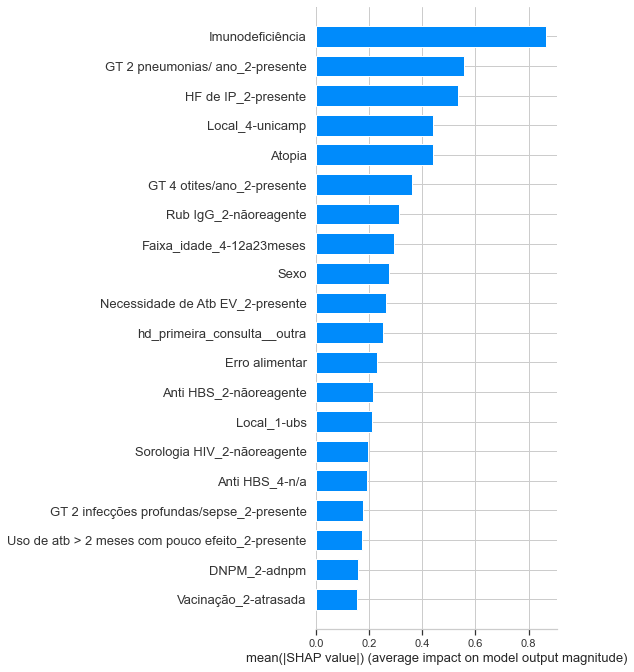

In [42]:
shap.summary_plot(shap_values, df.iloc[:,1:], plot_type="bar")

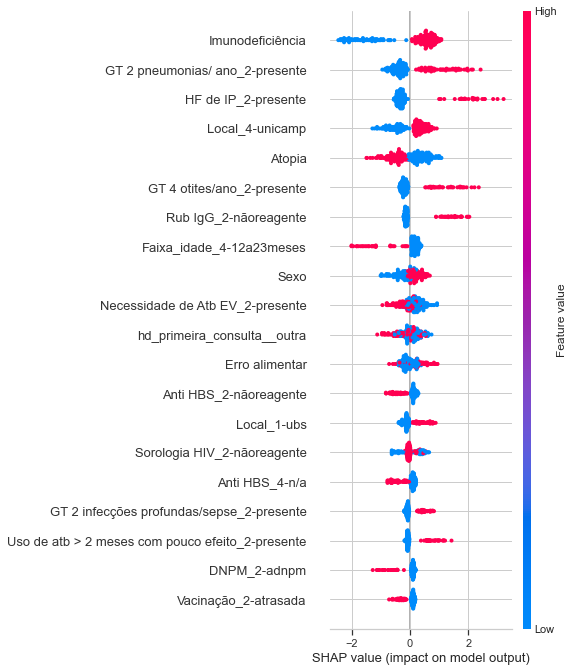

In [43]:
shap.summary_plot(shap_values, df.iloc[:,1:])

## Lime

In [44]:
import lime
import lime.lime_tabular

In [45]:
predict_fn_rf = lambda x: model.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(df.iloc[:,1:].values,feature_names = df.iloc[:,1:].columns,class_names=['Positive','Negative'],kernel_width=5)

In [46]:
df.iloc[1,1:]

Sexo                                                    0
Estado                                                  1
Erro alimentar                                          1
Atopia                                                  1
Imunodeficiência                                        0
Autoimunidade                                           0
Reação vacinal                                          0
hd_primeira_consulta__outra                             0
Anemia                                                  0
Leucopenia                                              0
Neutropenia                                             0
Linfopenia                                              0
Plaquetopenia                                           0
Eosenofilia                                             0
hemograma__outro                                        0
IgA                                                     0
IgG                                                     0
IgM           

In [47]:
exp = explainer.explain_instance(df.iloc[2,1:].values, predict_fn_rf,num_features=100)
exp.show_in_notebook(show_all=False)